# Machine Learning analysis on Persona User Survey 

## July 2020
by Jo for the team

In [84]:
import pandas as pd
import numpy as np
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize

In [85]:
def get_nmf_topics(model, n_topics, n_top_words):
    """
    Returns a table containing the top most frequent words for each topics. 
    Topics = survey answers in survey context OR features in NMF modelling language
    Words = personae in survey context OR components in NMF modelling language
    
        Parameters:
            model (sklearn.decomposition.NMF): NMF class fitted with a feature matrix.
            n_topics (positive int): n_components argument used to instanciate the NMF model.
            n_top_words (positive int): 
       
        Returns: 
            Table (DataFrame): Cols are topics (personaes), lines are top words (survey answers)
            
        Example: 
                
            n_comp = 4
            matrix = X.toarray()
            model = NMF(n_components= n_comp)
            model.fit(matrix)
            
            get_nmf_topics(model, n_comp, 10)
            
            
        >>> Persona # 1                   |  Persona # 2            |  Persona # 3                   |   Persona # 4
            ________________________________________________________________________________________________________________________
        0   activity_mountain_low         |  activity_commuting_low |  activity_fitnesstraining_high |  activity_chores/errands_high
        1   buyingref_onlinereviews_high  |  monthly_rider          |  buyingref_onlinereviews_high  |  rain

    """
    

    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = vec.get_feature_names()
    
    word_dict = {};
    for i in range(n_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-n_top_words - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Persona # ' + '{:2d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict)

In [86]:
def print_feat_freq(model, vec):
    """
    Takes the fitted model and token count (features) sparce matrix and 
    prints feature frequentcy for each components 
    """
    
    # Create a DataFrame: components_df
    components_df = pd.DataFrame(model.components_, columns= vec.get_feature_names())
    
    for x in range(0, components_df.shape[0]):
        print("\nPersona " + str(x+1))
        print("==========")
        component = components_df.iloc[x,:]
        print(component.nlargest(20))
        print("\n")

In [87]:
def b_trial(array, len_dataset= 1500):
    """
    Apply Bernouilli trials on an array and returns coefficient of success of
    event == 1
    """
    
    bt_unit = array[array == 1]
    success = len(bt_unit[bt_unit == True])
    return success / len_dataset

In [88]:
def bootstrap_replicate_1d(data, func): 
    """
    Generate bootstrap replicate of 1D data.
    """ 
    # Roll the dice the same number of time the size of dataset
    bs_sample = np.random.choice(data, 1500) 
    return func(bs_sample)

In [89]:
def conf_interval(n_events, cl= 98):
    """
    Give high and low percentile values for 10000 Bernouilli trials out of n_events possibilies.
    
        Parameters:
            n_events (positive int): maximum set of outcome. Ex. 6 faces dice is n_events=6
            cl (positive int): Confidence level of to estimate a range of values outside of which, 
                a value is deemed to statistically significant.
                
        Returns:
            Confidence interval (numpy array) highest and lowest end points or limits
    """
    
    
    # Init the choice pool
    bx = np.arange(1, n_events + 1)
    
    # Replicate the random experiment 10k times.
    bs_replicates = np.empty(10000)
    
    for i in range(10000):
        bs_replicates[i] = bootstrap_replicate_1d(bx, b_trial)
    
    # Calculating higher and lower percentiles (P)
    P_low = (100 - cl) / 2
    P_high = cl + (100 - cl) /2
    
    # Find values at lowest and highest P
    conf_int = np.percentile(bs_replicates, [P_low, P_high])
    
    return conf_int

In [90]:
def persona_ratio(df_nmf_feat, n_comp, conf_int):
    """
    Takes the NMF coefficient matrix and prints the representation 
    of each persona vs all respondant in percentage value.
    """

    parting_ratio = conf_int[1]
    total_pct = []

    for i in range(n_comp):
        
        df_test = df_nmf_feat[df_nmf_feat.iloc[:, i] >= parting_ratio]
        total_pct.append(df_test.shape[0] / df_nmf_feat.shape[0] * 100)
        
        print('Persona #{:1d} make for {:0.1f}% of all respondants'
              .format(i+1, df_test.shape[0] / df_nmf_feat.shape[0] * 100))

    print('All {:1d} personna profiles account for {:0.1f}% of all respondants'
          .format(n_comp, sum(total_pct)))

## Feature engineering to suit NMF modeling pipeline

In [18]:
# Load the cleaned up DataFrame.
df = pd.read_pickle('Input/PUS_20-06-08_responses(Compounded).pkl')

# Drop some useless columns for NMF model
dropcol = ['because_Other',
           'NOTbecause_Other', 
           'SH_versions', 
           'reason_Other',
           'infoFROM_Other', 
           'more_help', 
           'email', 
           'Original_Lang']

df.drop(columns= dropcol, 
        inplace=True)

In [916]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1502 entries, 0 to 208
Data columns (total 73 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   age                            1502 non-null   category
 1   gender                         1502 non-null   category
 2   platform                       1502 non-null   category
 3   income                         1502 non-null   category
 4   experience                     1502 non-null   uint8   
 5   rides_per_week                 1502 non-null   uint8   
 6   bike_type_Road                 434 non-null    category
 7   bike_type_Mountain             244 non-null    category
 8   bike_type_Hybrid               497 non-null    category
 9   bike_type_BikeShare            24 non-null     category
 10  bike_type_eBike                257 non-null    category
 11  bike_type_CruiserCity          148 non-null    category
 12  bike_type_Cargo                26 n

In [124]:
# Make a seperate DataFrame w/ emails and interest of respondant to 
# help us in future developments. To merge later with NMF feature matrix
df_names = pd.read_pickle('_Input/PUS_20-06-08_responses(Compounded).pkl')
df_names = df_names[['email', 'more_help']]
df_names.head()

,email,more_help
0,muellmuetze@gmx.de,1
1,michl.koch@gmail.com,1
2,JennRhodes.13@gmail.com,1
3,NaN,0
4,xrosee@live.cn,1


In [19]:
# Binning numerical data for NMF model
df['experience'] = df['experience'].apply(lambda x: 1 if x <= 6 
                                          else (2 if x <= 8 
                                                else 3)
                                         )
df['experience'] = df['experience'].astype('str')
df['experience'] = df['experience'].apply(lambda x: 'exp_LOW' if x == '1' 
                                          else ('exp_MID' if x == '2' 
                                                else 'exp_HIGH')
                                         )

df['rides_per_week'] = df['rides_per_week'].apply(lambda x: 1 if x <= 3 
                                                  else (2 if x <= 6 
                                                        else (3 if x <= 15 
                                                              else 4)
                                                       )
                                                 )
df['rides_per_week'] = df['rides_per_week'].astype('str')
df['rides_per_week'] = df['rides_per_week'].apply(lambda x: 'Monthly_rider' if x == '1' 
                                                  else ('Weekly_rider' if x == '2' 
                                                        else ('Daily_rider' if x == '3' 
                                                              else 'Hourly_rider')
                                                       )
                                                 )                                       

df['SH_usage'] = df['SH_usage'].apply(lambda x: 0 if x == 0 
                                      else (1 if x <= 2 
                                            else (2 if x == 3
                                                 else 3 )
                                           )
                                     )
df['SH_usage'] = df['SH_usage'].astype('str')
df['SH_usage'] = df['SH_usage'].apply(lambda x: 'LOW_user' if x == '1' 
                                      else ('MID_user' if x == '2' 
                                            else ('HIGH_user' if x == '3'
                                                 else 'NotYet_user' )
                                           )
                                     )


In [20]:
df['gender'].value_counts(normalize= True)

Male                 0.869507
Female               0.124501
Prefer not to say    0.003329
Non-binary           0.002663
Name: gender, dtype: float64

In [21]:
# Create list of column index number corresponding to the "Rank activity importance" question
ls_activity = np.arange(18, 27, 1)

# Replace numerical values for strings for NMF model
for i in ls_activity:
    df.iloc[:, i] = df.iloc[:, i].apply(lambda x: 1 if x <= 2 
                                        else (2 if x == 3 
                                              else 3)
                                       )
    df.iloc[:, i] = df.iloc[:, i].astype('str')
    df.iloc[:, i] = df.iloc[:, i].apply(lambda x: df.columns[i]+'_LOW' if x == '1' 
                                        else (df.columns[i]+'_MID' if x == '2' 
                                              else df.columns[i]+'_HIGH')
                                       )

In [22]:
# Create list of column index number corresponding to the "Rank activity importance" question
ls_buyREF = np.arange(60, 66, 1)

# Replace numerical values for strings for NMF model
for i in ls_buyREF:
    df.iloc[:, i] = df.iloc[:, i].apply(lambda x: 1 if x <= 2 
                                        else (2 if x == 3 else 3)
                                       )
    df.iloc[:, i] = df.iloc[:, i].astype('str')
    df.iloc[:, i] = df.iloc[:, i].apply(lambda x: df.columns[i]+'_LOW' if x == '1' 
                                        else (df.columns[i]+'_MID' if x == '2' 
                                              else df.columns[i]+'_HIGH')
                                       )

In [23]:
# Replace long answer that has ',' in it with short answer for tokennization
ls_env = list(df['environment'].unique())
ls_env_short = ['Town', 'City', 'Rural', 'Nature']

df['environment'].replace(to_replace= ls_env, 
                          value= ls_env_short, 
                          inplace= True)

df['bike_type_Folding'].replace(to_replace= 'Foldable bike', 
                          value= 'Folding bike', 
                          inplace= True)

# Replacing the ',' in the statement to avoid spliting it in 2 tokens at ",".join step
df['reason_helpMeSafe'].replace(to_replace= 'To help me stay safe (nightlight, safest routes)', 
                                value= 'To help me stay safe (nightlight - safest routes)',
                               inplace= True)

In [24]:
# Saving to pickle (dedicated format to save DataFrames)
#df.to_pickle('PUS_20-08-26_clean_4_ML.pkl')

### Some EDA on usage

In [22]:
df_lowUSE = df[df['SH_usage'] == 'LOW_user']
df_lowUSE['age'].value_counts(normalize= True)

35-44    0.278351
45-54    0.260309
55+      0.242268
25-34    0.180412
16-24    0.038660
Name: age, dtype: float64

In [23]:
df_midUSE = df[df['SH_usage'] == 'MID_user']
df_midUSE['age'].value_counts(normalize= True)

55+      0.295455
45-54    0.287879
35-44    0.253788
25-34    0.132576
16-24    0.030303
Name: age, dtype: float64

In [24]:
df_highUSE = df[df['SH_usage'] == 'HIGH_user']
df_highUSE['age'].value_counts(normalize= True)

45-54    0.272472
35-44    0.261236
55+      0.247191
25-34    0.178371
16-24    0.040730
Name: age, dtype: float64

In [25]:
df_notUSE = df[df['SH_usage'] == 'NotYet_user']
df_notUSE['age'].value_counts(normalize= True)

45-54    0.304348
35-44    0.268116
55+      0.239130
25-34    0.152174
16-24    0.036232
Name: age, dtype: float64

#### to strings

In [30]:
# Cast int8 type content as sting type to apply ",".join() method to create one 'sentance' for NMF input
ls_int8 = [4, 5,  17, 18, 19, 20, 21, 22, 23, 24, 25, 57, 59, 60, 61, 62, 63, 64]
df_World_str = pd.read_pickle('_Input/PUS_20-08-26_clean_4_ML.pkl')
df_World_str.drop(columns= 'location', inplace= True)

for i in ls_int8:
    df_World_str.iloc[:, i] = df_World_str.iloc[:, i].astype('str')

# Cast everything to string type to apply ",".join() method to create one 'sentance' for NMF input
df_World_str = df_World_str.astype('str')

#df_str.info()

In [31]:
# Make one sentance of all columns for NMF input
df_World_text = df_World_str.apply(lambda x: ", ".join(x), axis=1)

# Cleaning the 'nan' off the string.
ls_text = list(df_World_text)
i_ls_text = np.arange(0, len(ls_text), 1)

for i in i_ls_text:
    ls_text[i] = ls_text[i].replace(' nan,', '')

for i in i_ls_text:
    ls_text[i] = ls_text[i].replace(', nan', '')
    
df_World_text = pd.Series(ls_text)

In [27]:
df_World_text[2]

"25-34, Female, iOS, 72,000 or more, exp_MID, Monthly_rider, Hybrid bike, 750 - 1249, City, activity_Commuting_HIGH, activity_Chores/errands_HIGH, activity_WorkingTool_LOW, activity_elseTransportation_MID, activity_Mountain_LOW, activity_Touring_MID, activity_Racing_LOW, activity_FitnessTraining_LOW, activity_PleasureRides_HIGH, I want to reduce my environmental impact, It’s part of my identity/culture, It’s more fun, I don't know the way, I don't want to sweat, It's not safe for me, Temperate, Hot/Humid, To help me navigate, To help me stay safe (nightlight - safest routes), To help keep my bike safe, MID_user, I got my SmartHalo another way, buyingREF_Brand_HIGH, buyingREF_OnlineReviews_HIGH, buyingREF_Influencer_HIGH, buyingREF_Friend/family_HIGH, buyingREF_Price_HIGH, buyingREF_myNeeds_HIGH, Online forums, Chats with friends or family, Retail stores/shops"

# World

## NMF modeling

In [32]:
# Instantiate the CountVectorizer: vec
vec = CountVectorizer(tokenizer= lambda x: x.split(', '))  # Object to convert in matrix of token counts 

# Fit to the data
X = vec.fit_transform(df_World_text) # Convert df.bike_type to matrix of token
print("There are {} tokens in the dataset".format(len(vec.get_feature_names())))

# X_train, X_test, y_train, y_test = train_test_split(vec, random_state=456)
df_matrix = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

There are 134 tokens in the dataset


In [33]:
vec.get_feature_names()

['1250 - 1999',
 '16-24',
 '2000 - 3499',
 '22,000 - 35,999',
 '25-34',
 '35-44',
 '3500 - 4999',
 '36,000 - 54,999',
 '45-54',
 '500 - 749',
 '5000 or more',
 '55+',
 '55,000 - 71,999',
 '72,000 or more',
 '750 - 1249',
 'activity_chores/errands_high',
 'activity_chores/errands_low',
 'activity_chores/errands_mid',
 'activity_commuting_high',
 'activity_commuting_low',
 'activity_commuting_mid',
 'activity_elsetransportation_high',
 'activity_elsetransportation_low',
 'activity_elsetransportation_mid',
 'activity_fitnesstraining_high',
 'activity_fitnesstraining_low',
 'activity_fitnesstraining_mid',
 'activity_mountain_high',
 'activity_mountain_low',
 'activity_mountain_mid',
 'activity_pleasurerides_high',
 'activity_pleasurerides_low',
 'activity_pleasurerides_mid',
 'activity_racing_high',
 'activity_racing_low',
 'activity_racing_mid',
 'activity_touring_high',
 'activity_touring_low',
 'activity_touring_mid',
 'activity_workingtool_high',
 'activity_workingtool_low',
 'activity

### 4 Personas - World

In [34]:
n_comp = 4

# Fit the NMF for X number of personas (n_components)
matrix = X.toarray()
model = NMF(n_components= n_comp)
model.fit(matrix)
nmf_features = model.transform(matrix)

# Create a DataFrame: components_df
components_df = pd.DataFrame(model.components_, columns= vec.get_feature_names())

# Print the shape of the DataFrame
print(components_df.shape)

for x in range(0, components_df.shape[0]):
    print("\nPersona " + str(x))
    print("==========")
    component = components_df.iloc[x,:]
    print(component.nlargest(10))
    print("\n")

(4, 134)

Persona 0
activity_mountain_low                       2.329563
buyingref_onlinereviews_high                2.202790
activity_touring_low                        2.004925
activity_racing_low                         1.972837
buyingref_myneeds_high                      1.967729
activity_workingtool_low                    1.828885
buyingref_friend/family_high                1.808637
buyingref_price_high                        1.791676
i want to reduce my environmental impact    1.728067
temperate                                   1.676150
Name: 0, dtype: float64



Persona 1
activity_commuting_low             1.951457
monthly_rider                      1.838742
activity_elsetransportation_low    1.735745
activity_racing_low                1.662542
activity_workingtool_low           1.600693
the weather doesn't suit me        1.543899
activity_chores/errands_low        1.536156
temperate                          1.500639
i want to be healthy               1.422368
male             

In [42]:
get_nmf_topics(model, n_comp, 10)

,Persona # 1,Persona # 2,Persona # 3,Persona # 4
0,activity_mountain_low,activity_commuting_low,activity_fitnesstraining_high,activity_chores/errands_high
1,buyingref_onlinereviews_high,monthly_rider,buyingref_onlinereviews_high,rain
2,activity_touring_low,activity_elsetransportation_low,buyingref_friend/family_high,activity_elsetransportation_high
3,activity_racing_low,activity_racing_low,buyingref_price_high,activity_commuting_high
4,buyingref_myneeds_high,activity_workingtool_low,activity_touring_high,exp_high
5,activity_workingtool_low,the weather doesn't suit me,activity_pleasurerides_high,hot/humid
6,buyingref_friend/family_high,activity_chores/errands_low,buyingref_myneeds_high,snow/ice
7,buyingref_price_high,temperate,buyingref_brand_high,daily_rider
8,i want to reduce my environmental impact,i want to be healthy,it’s my hobby/interest,to help me navigate
9,temperate,male,i want to be healthy,temperate


### 5 personas - World

In [43]:
n_comp = 5

# Fit the NMF for X number of personas (n_components)
matrix = X.toarray()
model = NMF(n_components= n_comp)
model.fit(matrix)
nmf_features = model.transform(matrix)

# Create a DataFrame: components_df
components_df = pd.DataFrame(model.components_, columns= vec.get_feature_names())

# Print the shape of the DataFrame
print(components_df.shape)

for x in range(0, components_df.shape[0]):
    print("\nPersona " + str(x))
    print("==========")
    component = components_df.iloc[x,:]
    print(component.nlargest(10))
    print("\n")

(5, 134)

Persona 0
activity_mountain_low                       2.301332
activity_touring_low                        2.130630
buyingref_influencer_low                    1.988304
activity_racing_low                         1.954626
activity_fitnesstraining_low                1.885399
activity_workingtool_low                    1.856715
buyingref_myneeds_high                      1.789806
buyingref_onlinereviews_high                1.784818
i want to reduce my environmental impact    1.647325
temperate                                   1.646569
Name: 0, dtype: float64



Persona 1
activity_commuting_low             1.942099
activity_elsetransportation_low    1.756970
monthly_rider                      1.753528
activity_racing_low                1.678370
the weather doesn't suit me        1.583672
ios                                1.543346
activity_chores/errands_low        1.526732
activity_workingtool_low           1.458624
i want to be healthy               1.391225
temperate        

In [44]:
get_nmf_topics(model, n_comp, 10)

,Persona # 1,Persona # 2,Persona # 3,Persona # 4,Persona # 5
0,activity_mountain_low,activity_commuting_low,buyingref_brand_high,rain,activity_touring_high
1,activity_touring_low,activity_elsetransportation_low,buyingref_price_high,activity_chores/errands_high,activity_fitnesstraining_high
2,buyingref_influencer_low,monthly_rider,buyingref_onlinereviews_high,activity_elsetransportation_high,activity_pleasurerides_high
3,activity_racing_low,activity_racing_low,buyingref_friend/family_high,activity_commuting_high,male
4,activity_fitnesstraining_low,the weather doesn't suit me,buyingref_myneeds_high,exp_high,it’s my hobby/interest
5,activity_workingtool_low,ios,activity_pleasurerides_high,snow/ice,i backed smarthalo 2
6,buyingref_myneeds_high,activity_chores/errands_low,ios,hot/humid,buyingref_myneeds_high
7,buyingref_onlinereviews_high,activity_workingtool_low,it's not safe for me,daily_rider,activity_mountain_high
8,i want to reduce my environmental impact,i want to be healthy,activity_fitnesstraining_high,temperate,buyingref_friend/family_high
9,temperate,temperate,i want to be healthy,male,online forums


### 6 Personas - World

In [45]:
# Fit the NMF for X number of personas (n_components)
n_comp = 6

matrix = X.toarray()
model = NMF(n_components= n_comp)
model.fit(matrix)
nmf_features = model.transform(matrix)

# Create a DataFrame: components_df
components_df = pd.DataFrame(model.components_, columns= vec.get_feature_names())

# Print the shape of the DataFrame
print(components_df.shape)

for x in range(0, components_df.shape[0]):
    print("\nPersona " + str(x))
    print("==========")
    component = components_df.iloc[x,:]
    print(component.nlargest(10))
    print("\n")

(6, 134)

Persona 0
activity_mountain_low           2.462125
activity_touring_low            2.291871
activity_fitnesstraining_low    2.272714
buyingref_influencer_low        2.002505
city                            1.967032
activity_racing_low             1.914445
buyingref_onlinereviews_high    1.890784
activity_workingtool_low        1.793911
buyingref_myneeds_high          1.777168
the route is too long/steep     1.670757
Name: 0, dtype: float64



Persona 1
activity_commuting_low             2.277777
monthly_rider                      2.052742
activity_elsetransportation_low    1.973543
activity_chores/errands_low        1.783674
ios                                1.664700
the weather doesn't suit me        1.575332
55+                                1.501799
activity_racing_low                1.455817
activity_workingtool_low           1.385460
temperate                          1.324269
Name: 1, dtype: float64



Persona 2
buyingref_brand_high             2.063964
buyingref_pric

In [46]:
get_nmf_topics(model, n_comp, 10)

,Persona # 1,Persona # 2,Persona # 3,Persona # 4,Persona # 5,Persona # 6
0,activity_mountain_low,activity_commuting_low,buyingref_brand_high,rain,activity_fitnesstraining_high,high_user
1,activity_touring_low,monthly_rider,buyingref_price_high,activity_chores/errands_high,activity_touring_high,to help keep my bike safe
2,activity_fitnesstraining_low,activity_elsetransportation_low,buyingref_onlinereviews_high,activity_elsetransportation_high,buyingref_friend/family_high,buyingref_brand_mid
3,buyingref_influencer_low,activity_chores/errands_low,buyingref_friend/family_high,exp_high,online forums,buyingref_influencer_mid
4,city,ios,high_user,activity_commuting_high,activity_mountain_high,buyingref_price_mid
5,activity_racing_low,the weather doesn't suit me,to help keep my bike safe,snow/ice,buyingref_onlinereviews_high,town
6,buyingref_onlinereviews_high,55+,buyingref_myneeds_high,daily_rider,male,activity_racing_low
7,activity_workingtool_low,activity_racing_low,activity_fitnesstraining_high,hot/humid,buyingref_myneeds_high,activity_fitnesstraining_mid
8,buyingref_myneeds_high,activity_workingtool_low,buyingref_influencer_high,to help me navigate,it’s my hobby/interest,buyingref_friend/family_mid
9,the route is too long/steep,temperate,i want to be healthy,ios,activity_pleasurerides_high,i want to be healthy


## World without Buying preference and information source questions

In [91]:
df_World_str = pd.read_pickle('PUS_20-08-26_clean_4_ML.pkl')

# Cast int8 type content as sting type to apply ",".join() method to create one 'sentance' for NMF input
ls_int8 = [4, 5,  17, 18, 19, 20, 21, 22, 23, 24, 25, 57]
# Drop all BuyingREF and infoFROM columns
dropcol2 = df_World_str.columns[59:]
df_Worlsimp_str = df_World_str.drop(columns= dropcol2)
# Drop location column
df_Worlsimp_str.drop(columns= 'location', inplace= True)

# Cast int8 to strings
for i in ls_int8:
    df_Worlsimp_str.iloc[:, i] = df_Worlsimp_str.iloc[:, i].astype('str')

# Cast everything to sting type to apply ",".join() method to create one 'sentance' for NMF input
df_Worlsimp_str = df_Worlsimp_str.astype('str')

#df_str.info()

In [92]:
# Make a list of features in the same order as question were asked.
# run the cell below

In [93]:
col_order_withoutBuyRef = ['16-24',
 '25-34',
 '35-44',
 '45-54',
 '55+',
 'male',
 'female',
 'non-binary',
 'prefer not to say',
 'ios',
 'android',
 'less than 21,999',
 '22,000 - 35,999',
 '36,000 - 54,999',
 '55,000 - 71,999',
 '72,000 or more',
 'less than 499',
 'exp_low',
 'exp_mid',
 'exp_high',
 'hourly_rider',
 'daily_rider',
 'weekly_rider',
 'monthly_rider',
 'road bike',
 'mountain bike',
 'hybrid bike',
 'bike share bike',
 'e-bike',
 'cruiser / city bike',
 'cargo bike',
 'single-speed bike',
 'folding bike',
 '500 - 749',
 '750 - 1249',
 '1250 - 1999',
 '2000 - 3499',
 '3500 - 4999',
 '5000 or more',
 'city',
 'town',
 'rural',
 'nature',
 'activity_commuting_low',
 'activity_commuting_mid',
 'activity_commuting_high',
 'activity_chores/errands_low',
 'activity_chores/errands_mid',
 'activity_chores/errands_high',
 'activity_workingtool_low',
 'activity_workingtool_mid',
 'activity_workingtool_high',
 'activity_elsetransportation_low',
 'activity_elsetransportation_mid',
 'activity_elsetransportation_high',
 'activity_mountain_low',
 'activity_mountain_mid',
 'activity_mountain_high',
 'activity_touring_low',
 'activity_touring_mid',
 'activity_touring_high',
 'activity_racing_low',
 'activity_racing_mid',
 'activity_racing_high',
 'activity_fitnesstraining_low',
 'activity_fitnesstraining_mid',
 'activity_fitnesstraining_high',
 'activity_pleasurerides_low',
 'activity_pleasurerides_mid',
 'activity_pleasurerides_high',
 'it’s more convenient',
 'it’s more reliable',
 'it’s faster',
 'it’s cheaper',
 'i want to reduce my environmental impact',
 'i want to be healthy',
 'i have friends/family who also bike',
 'it’s my hobby/interest',    
 'it’s part of my identity/culture',
 'it’s more fun',
 "the weather doesn't suit me",
 'the route is too long/steep',
 "i don't know the way",
 'i have to carry things with me',
 "i don't want to sweat",
 "it's not safe for me",
 "it's not safe for my bike",
 'i feel lazy',
 "it wouldn't be fun",
 "it's too dark",
 'temperate',
 'hot/humid', 
 'rain',
 'snow/ice',
 'to help me navigate',
 'to help me keep track of my fitness goals',
 'to help me keep track of my environmental goals',
 'to help me stay safe (nightlight - safest routes)',
 'to help keep my bike safe',
 "so i don't have to look at my phone while riding",
 "because it's cool!",
 'low_user',
 'mid_user',
 'high_user',
 'notyet_user',]

In [94]:
# Make one sentance of all columns for NMF input
df_Worlsimp_text = df_Worlsimp_str.apply(lambda x: ", ".join(x), axis=1)
df_Worlsimp_text.head()

0    35-44, Male, Android, 36,000 - 54,999, exp_LOW...
1    35-44, Male, Android, 72,000 or more, exp_HIGH...
2    25-34, Female, iOS, 72,000 or more, exp_MID, M...
3    35-44, Male, iOS, 72,000 or more, exp_MID, Dai...
4    35-44, Male, iOS, 22,000 - 35,999, exp_MID, Da...
dtype: object

In [95]:
# Cleaning the 'nan' off the string.
ls_text = list(df_Worlsimp_text)
i_ls_text = np.arange(0, len(ls_text), 1)
for i in i_ls_text:
    ls_text[i] = ls_text[i].replace(' nan,', '')
    
df_Worlsimp_text = pd.Series(ls_text)
df_Worlsimp_text[0]

"35-44, Male, Android, 36,000 - 54,999, exp_LOW, Monthly_rider, Single-speed bike, 1250 - 1999, Town, activity_Commuting_HIGH, activity_Chores/errands_LOW, activity_WorkingTool_LOW, activity_elseTransportation_LOW, activity_Mountain_LOW, activity_Touring_MID, activity_Racing_LOW, activity_FitnessTraining_HIGH, activity_PleasureRides_LOW, I want to reduce my environmental impact, I want to be healthy, It’s my hobby/interest, The weather doesn't suit me, I have to carry things with me, It wouldn't be fun, Temperate, Hot/Humid, Rain, To help me navigate, To help me keep track of my environmental goals, To help keep my bike safe, HIGH_user"

In [6]:
df_Worlsimp_text

0       35-44, Male, Android, 36,000 - 54,999, exp_LOW...
1       35-44, Male, Android, 72,000 or more, exp_HIGH...
2       25-34, Female, iOS, 72,000 or more, exp_MID, M...
3       35-44, Male, iOS, 72,000 or more, exp_MID, Dai...
4       35-44, Male, iOS, 22,000 - 35,999, exp_MID, Da...
                              ...                        
1497    25-34, Male, iOS, 22,000 - 35,999, exp_MID, Mo...
1498    25-34, Male, iOS, 36,000 - 54,999, exp_MID, Da...
1499    45-54, Male, iOS, Prefer not to say, exp_LOW, ...
1500    25-34, Male, Android, Prefer not to say, exp_M...
1501    45-54, Male, iOS, 72,000 or more, exp_MID, Mon...
Length: 1502, dtype: object

In [119]:
df_Worlsimp_text.shape

(1502,)

In [120]:
df_Worlsimp_text[1000]

"25-34, Female, Android, 72,000 or more, exp_LOW, Monthly_rider, Hybrid bike, 500 - 749, Town, activity_Commuting_MID, activity_Chores/errands_LOW, activity_WorkingTool_LOW, activity_elseTransportation_HIGH, activity_Mountain_LOW, activity_Touring_HIGH, activity_Racing_LOW, activity_FitnessTraining_MID, activity_PleasureRides_HIGH, I want to be healthy, It’s my hobby/interest, It’s more fun, The weather doesn't suit me, I have to carry things with me, It's not safe for me, Temperate, Hot/Humid, To help me navigate, To help keep my bike safe, So I don't have to look at my phone while riding, MID_user"

## NMF modeling

In [96]:
# Instantiate the CountVectorizer: vec
vec = CountVectorizer(tokenizer=lambda x: x.split(', '))  # Object to convert in matrix of token counts 

# Fit to the data
X = vec.fit_transform(df_Worlsimp_text) # Convert df.bike_type to matrix of token
print("There are {} tokens in the dataset".format(len(vec.get_feature_names())))

# X_train, X_test, y_train, y_test = train_test_split(vec, random_state=456)
df_matrix = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

There are 105 tokens in the dataset


### 4 Personas - World - w/o BuyingREF

In [766]:
# Fit the NMF for X number of personas (n_components)
n_comp = 4

matrix = X.toarray()
model = NMF(n_components= n_comp)
model.fit(matrix)
nmf_features = model.transform(matrix)

In [767]:
print_feat_freq(model, vec)


Persona 1
activity_mountain_low               2.303434
city                                2.110032
activity_commuting_high             2.069347
activity_fitnesstraining_low        2.054801
activity_touring_low                1.932181
activity_racing_low                 1.907220
ios                                 1.879132
activity_chores/errands_high        1.800024
temperate                           1.743833
activity_workingtool_low            1.647915
the route is too long/steep         1.593711
male                                1.520272
it’s more convenient                1.487877
hot/humid                           1.478271
to help me navigate                 1.439263
the weather doesn't suit me         1.340791
rain                                1.334825
daily_rider                         1.301870
activity_elsetransportation_high    1.224842
it’s faster                         1.222959
Name: 0, dtype: float64



Persona 2
activity_commuting_low             2.052915
monthly_

In [768]:
get_nmf_topics(model, n_comp, 10)

,Persona # 1,Persona # 2,Persona # 3,Persona # 4
0,activity_mountain_low,activity_commuting_low,activity_touring_high,high_user
1,city,monthly_rider,activity_elsetransportation_high,to help keep my bike safe
2,activity_commuting_high,the weather doesn't suit me,rain,activity_racing_low
3,activity_fitnesstraining_low,activity_workingtool_low,activity_chores/errands_high,i want to be healthy
4,activity_touring_low,activity_elsetransportation_low,activity_pleasurerides_high,i want to reduce my environmental impact
5,activity_racing_low,temperate,exp_high,town
6,ios,ios,activity_fitnesstraining_high,android
7,activity_chores/errands_high,activity_pleasurerides_high,hot/humid,activity_mountain_low
8,temperate,i want to be healthy,activity_commuting_high,activity_fitnesstraining_mid
9,activity_workingtool_low,activity_chores/errands_low,temperate,activity_workingtool_low


In [769]:
# Set a DataFrame with coefficient matrix (how much each sample belongs to a persona)
col_nmf = ['Persona # ' + '{:2d}'.format(i+1) for i in range(0, n_comp)]
df_nmf_feat = pd.DataFrame(nmf_features, 
                           columns= col_nmf)

In [770]:
df_nmf_feat

,Persona # 1,Persona # 2,Persona # 3,Persona # 4
0,0.080650,0.214218,0.041282,0.329541
1,0.287495,0.000000,0.090836,0.340546
2,0.266451,0.077295,0.000000,0.257627
3,0.485400,0.047939,0.086783,0.000000
4,0.285258,0.000000,0.195551,0.252179
...,...,...,...,...
1497,0.180332,0.278708,0.125475,0.045103
1498,0.295111,0.000000,0.128135,0.288647
1499,0.315597,0.156300,0.001466,0.168113
1500,0.225487,0.158057,0.000000,0.120762


In [814]:
# Getting value range with 98% confidence interval
conf_int_4 = conf_interval(4, cl= 98)

# Printing total proportion of respondants for all Personaes
# Note that the sum doesn't = 100% because of the way each personae ensemble is calculated.
persona_ratio(df_nmf_feat, n_comp, conf_int_4)

Persona #1 make for 18.3% of all respondants
Persona #2 make for 27.4% of all respondants
Persona #3 make for 17.1% of all respondants
Persona #4 make for 17.7% of all respondants
All 4 personna profiles account for 80.5% of all respondants


### 5 personas - World - w/o BuyingREF

In [139]:
n_comp = 5

# Fit the NMF for X number of personas (n_components)
matrix = X.toarray()
model = NMF(n_components= n_comp)
model.fit(matrix)
nmf_features = model.transform(matrix)

In [98]:
components_df = pd.DataFrame(model.components_, columns= vec.get_feature_names())
components_df = components_df[col_order_withoutBuyRef]
components_df

,16-24,25-34,35-44,45-54,55+,male,female,non-binary,prefer not to say,ios,...,to help me keep track of my fitness goals,to help me keep track of my environmental goals,to help me stay safe (nightlight - safest routes),to help keep my bike safe,so i don't have to look at my phone while riding,because it's cool!,low_user,mid_user,high_user,notyet_user
0,0.000000,0.000000,0.000000,1.042373,0.811341,1.217347,0.339476,0.000000,0.215053,3.208876,...,1.244929,0.194845,1.425920,2.097549,0.000000,0.000000,0.000000,0.042919,2.014091,0.119875
1,0.024551,0.000000,0.275540,0.336772,1.038782,1.535349,0.171993,0.000000,0.604222,1.001541,...,0.494149,0.000000,0.136308,0.000000,1.056023,0.885101,0.834991,0.462927,0.000000,0.231280
2,0.177107,0.477652,0.470002,0.234557,0.000000,1.423145,0.001821,0.006795,0.557131,0.320205,...,0.000000,0.077612,0.273047,0.000000,1.030057,0.705492,0.634307,0.271518,0.000000,0.124444
3,0.079240,0.497174,0.382448,0.142510,0.000000,0.926590,0.135760,0.000000,0.000000,0.000000,...,0.412119,0.118298,0.628884,1.717451,0.186771,0.000000,0.000000,0.000000,1.733659,0.000000
4,0.003051,0.362618,0.890870,0.324949,0.000000,1.408750,0.255993,0.019808,0.158540,0.865458,...,0.000000,0.051992,0.077332,0.330127,1.036227,1.075593,0.539203,0.565006,0.000000,0.164344


#### Heat map of the first half of feature coefficient matrix

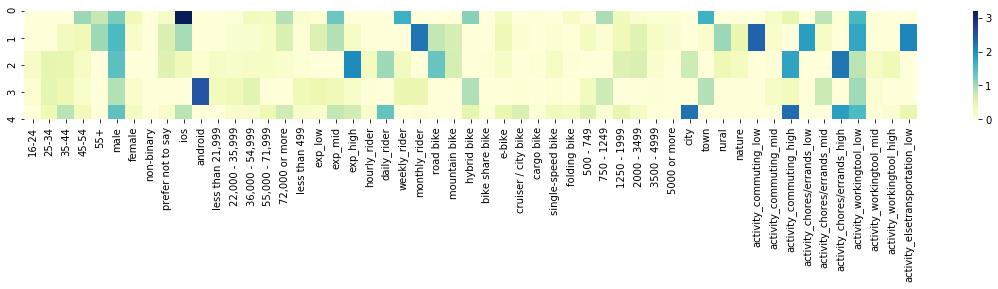

In [105]:
# Set highest value in the whole heatmap to keep same scale in the 2 halfs of it
# See next cell for second half
vmax = components_df.max().max() 
plt.figure(figsize=[20,2])
_=sns.heatmap(components_df.iloc[:, :53], 
              cmap="YlGnBu", 
              annot=False, 
              cbar=True,
             vmax=vmax)

#### Heat map of the second half of feature coefficient matrix

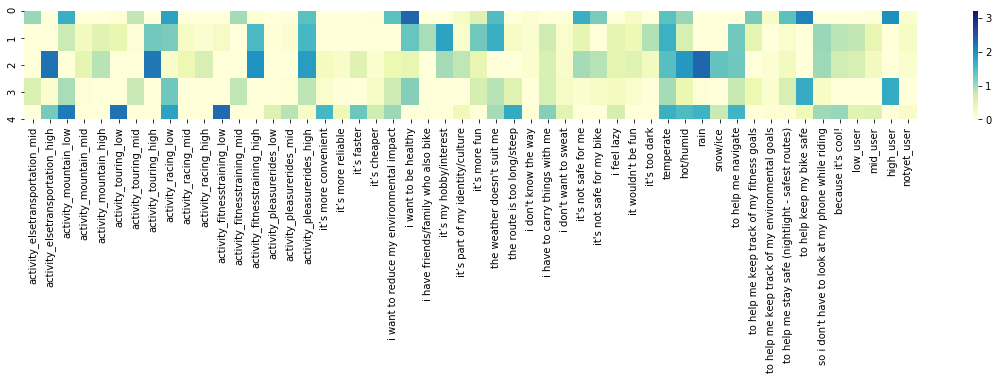

In [104]:
plt.figure(figsize=[20,2])
_=sns.heatmap(components_df.iloc[:, 53:], 
              cmap="YlGnBu", 
              annot=False, 
              cbar=True,
             vmax=vmax)

In [64]:
print_feat_freq(model, vec)


Persona 1
it's not safe for me                                 2.541493
ios                                                  2.008379
i want to reduce my environmental impact             1.943566
it's not safe for my bike                            1.868228
i want to be healthy                                 1.756399
rain                                                 1.712705
hot/humid                                            1.655702
activity_chores/errands_high                         1.637452
activity_racing_low                                  1.626949
activity_commuting_high                              1.594360
to help keep my bike safe                            1.477650
activity_pleasurerides_high                          1.461197
temperate                                            1.424539
high_user                                            1.367922
to help me stay safe (nightlight - safest routes)    1.365035
activity_elsetransportation_high                     1.2715

In [197]:
get_nmf_topics(model, n_comp, 10)

,Persona # 1,Persona # 2,Persona # 3,Persona # 4,Persona # 5
0,it's not safe for me,activity_commuting_low,activity_fitnesstraining_high,high_user,activity_fitnesstraining_low
1,rain,monthly_rider,activity_touring_high,to help keep my bike safe,city
2,activity_chores/errands_high,activity_elsetransportation_low,exp_high,android,activity_mountain_low
3,ios,ios,activity_pleasurerides_high,i want to be healthy,activity_touring_low
4,activity_commuting_high,activity_workingtool_low,male,activity_racing_low,activity_commuting_high
5,activity_elsetransportation_high,activity_chores/errands_low,road bike,activity_chores/errands_mid,it’s more convenient
6,it's not safe for my bike,i want to be healthy,it’s my hobby/interest,i want to reduce my environmental impact,activity_racing_low
7,hot/humid,the weather doesn't suit me,hot/humid,male,temperate
8,i want to reduce my environmental impact,temperate,to help me navigate,activity_workingtool_low,the route is too long/steep
9,activity_racing_low,activity_pleasurerides_high,so i don't have to look at my phone while riding,the weather doesn't suit me,to help me navigate


In [1075]:
# Set a DataFrame with coefficient matrix (how much each sample belongs to a persona)
col_nmf = ['Persona # ' + '{:2d}'.format(i+1) for i in range(0, n_comp)]
df_nmf_feat = pd.DataFrame(nmf_features, 
                           columns= col_nmf)

In [1076]:
df_nmf_feat

,Persona # 1,Persona # 2,Persona # 3,Persona # 4,Persona # 5
0,0.065116,0.184383,0.049148,0.322152,0.086426
1,0.240931,0.000000,0.087600,0.290977,0.156257
2,0.273719,0.085854,0.014863,0.190575,0.055592
3,0.436242,0.000000,0.084734,0.000000,0.198137
4,0.235453,0.000000,0.194301,0.184257,0.199864
...,...,...,...,...,...
1497,0.146944,0.201328,0.117779,0.000000,0.276630
1498,0.273073,0.000000,0.141003,0.226169,0.114067
1499,0.281843,0.102215,0.021285,0.159565,0.142158
1500,0.232633,0.151564,0.000000,0.088425,0.069474


In [1077]:
# Getting value range with 98% confidence interval
conf_int_5 = conf_interval(5, cl= 98)

# Printing total proportion of respondants for all Personaes
# Note that the sum doesn't = 100% because of the way each personae ensemble is calculated.
persona_ratio(df_nmf_feat, n_comp, conf_int_5)

Persona #1 make for 23.4% of all respondants
Persona #2 make for 30.6% of all respondants
Persona #3 make for 25.3% of all respondants
Persona #4 make for 22.4% of all respondants
Persona #5 make for 15.8% of all respondants
All 5 personna profiles account for 117.5% of all respondants


In [1079]:
WORLD_5P_woBRef_top_components = get_nmf_topics(model, 5, 10)
WORLD_5P_woBRef_top_components.to_csv('WORLD_5P_woBRef_top_components.csv', index= False)
df_nmf_feat.to_csv('WORLD_5P_woBRef_NMFfeat.csv', index= False)

### Bootstraping replication of NMF

NMF is an optimization algorythm that factorizes a matrix (containing no zeros, hence the name) into to smaller dimentioned matrices. This optimization process is an iterative one that never ends with the same results everytime it runs. Therefore, if we replicate the calculations of the algo several times, we will end up with a distribution of results. This distribution as properties like any statistical distribution. Assuming it's a normal one, we can extract a mean, median, standard deviation, etc, from it. Here, we just extract the mean for each coefficient value, leading us to a statistically significant factorization ( reliable market segments ).

In [222]:
# Init a matrix of zeros of shape (n_components, n_features)
init_data_components = np.array([[0]*105]*5)
init_data_features = np.array([[0]*5]*1502)

# Init empty DataFrame of shape (n_components, n_features)
temp_components_df = pd.DataFrame(init_data_components, columns= col_order_withoutBuyRef)
temp_features_df = pd.DataFrame(init_data_features, columns= list(range(5)))

# Set how many times we want to retrain the model
n_replication = np.arange(1, 10000)

for i in n_replication:
    # Init the model
    model = NMF(n_components= n_comp)
    # Train the model
    model.fit(matrix)    
    
    # Get the components matrix as df
    new_temp_components_df = pd.DataFrame(model.components_, columns= vec.get_feature_names())
    new_temp_components_df = new_temp_components_df[col_order_withoutBuyRef]
    
    # Get the features matrix as df
    nmf_features = model.transform(matrix)
    new_temp_features_df = pd.DataFrame(nmf_features)
    
    # Add the result to previous ones
    temp_components_df = temp_components_df + new_temp_components_df
    temp_features_df = temp_features_df + new_temp_features_df
    
bootstraped_components_df = temp_components_df / len(n_replication)
bootstraped_features_df = temp_features_df / len(n_replication)

#comp_df = pd.DataFrame(comp_array, columns= vec.get_feature_names())
bootstraped_components_df

,16-24,25-34,35-44,45-54,55+,male,female,non-binary,prefer not to say,ios,...,to help me keep track of my fitness goals,to help me keep track of my environmental goals,to help me stay safe (nightlight - safest routes),to help keep my bike safe,so i don't have to look at my phone while riding,because it's cool!,low_user,mid_user,high_user,notyet_user
0,0.003539,0.033799,0.010259,0.961741,0.744898,1.131054,0.375971,0.004974,0.268234,2.907649,...,1.097897,0.188789,1.402899,1.940022,0.001270,0.001347,0.000623,0.075124,1.840518,0.134634
1,0.019629,0.000000,0.234544,0.363668,1.082194,1.493629,0.196837,0.000000,0.593866,1.179514,...,0.548192,0.002317,0.220165,0.082053,0.981400,0.823270,0.768458,0.455030,0.050546,0.238812
2,0.186999,0.501755,0.511302,0.203425,0.000003,1.476278,0.000909,0.005073,0.526063,0.244261,...,0.003733,0.072918,0.205734,0.003875,1.135270,0.747548,0.701894,0.252282,0.001925,0.105053
3,0.070853,0.437177,0.373317,0.215320,0.003382,0.981882,0.101946,0.000000,0.000006,0.000000,...,0.463370,0.130397,0.609312,1.739114,0.125558,0.014013,0.000000,0.000000,1.778989,0.000000
4,0.007357,0.372507,0.899711,0.318576,0.000825,1.419582,0.239787,0.017472,0.147596,0.989092,...,0.001262,0.044296,0.081351,0.311183,1.099838,1.100233,0.566067,0.563817,0.002261,0.156731


#### Top features coefficient (answer) for each components (personas)

In [223]:
for x in range(0, bootstraped_components_df.shape[0]):
    print("\nPersona " + str(x+1))
    print("==========")
    component = components_df.iloc[x,:]
    print(component.nlargest(20))
    print("\n")


Persona 1
ios                                                  3.208876
i want to be healthy                                 2.354941
to help keep my bike safe                            2.097549
high_user                                            2.014091
activity_racing_low                                  1.837964
it's not safe for me                                 1.691958
activity_mountain_low                                1.686800
weekly_rider                                         1.658267
town                                                 1.649331
activity_workingtool_low                             1.556386
the weather doesn't suit me                          1.495432
temperate                                            1.435598
i want to reduce my environmental impact             1.433881
activity_pleasurerides_high                          1.429948
to help me stay safe (nightlight - safest routes)    1.425920
exp_mid                                              1.3263

In [224]:
persona_name_list = ['Persona #1', 'Persona #2', 'Persona #3', 'Persona #4', 'Persona #5']
bootstraped_features_df.columns = persona_name_list

#### Heat map of the first half of feature coefficient matrix

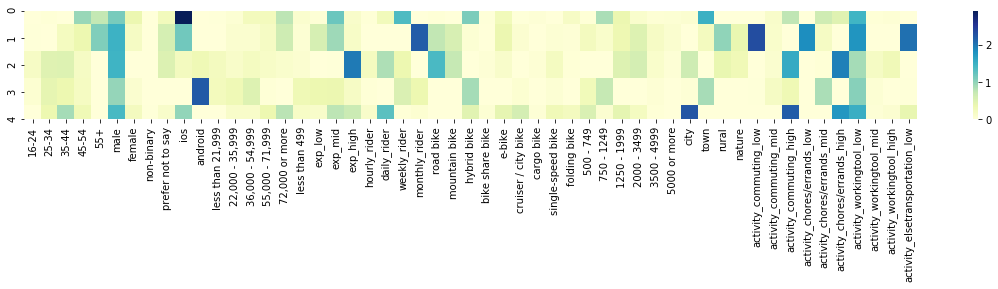

In [225]:
# Set highest value in the whole heatmap to keep same scale in the 2 halfs of it
# See next cell for second half
vmax = bootstraped_components_df.max().max() 
plt.figure(figsize=[20,2])
_=sns.heatmap(bootstraped_components_df.iloc[:, :53], 
              cmap="YlGnBu", 
              annot=False, 
              cbar=True,
             vmax=vmax)

#### Heat map of the second half of feature coefficient matrix

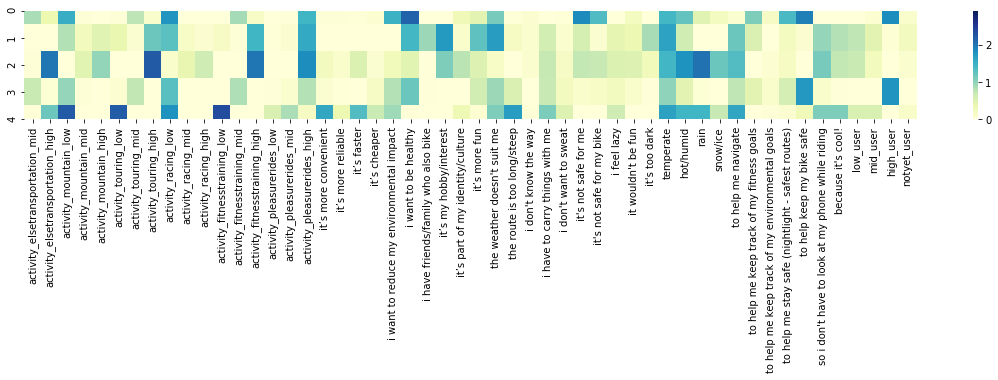

In [226]:
plt.figure(figsize=[20,2])
_=sns.heatmap(bootstraped_components_df.iloc[:, 53:], 
              cmap="YlGnBu", 
              annot=False, 
              cbar=True,
             vmax=vmax)

In [227]:
# Sum all coefficients (answer's weight) for each component (segments)
for i in range(5):
    print(bootstraped_components_df.iloc[i,:].sum())

47.00337336118622
50.07210173537442
48.88560654607925
32.37932826783654
53.714299499644234


In [228]:
# Add email to features matrix to id the respondant for further interview
bootstraped_features_df['email'] = df_names['email'].values
bootstraped_features_df['more_help'] = df_names['more_help'].values
bootstraped_features_df

,Persona #1,Persona #2,Persona #3,Persona #4,Persona #5,email,more_help
0,0.005078,0.197369,0.053489,0.455533,0.077107,muellmuetze@gmx.de,1
1,0.057602,0.000000,0.058422,0.407215,0.283995,michl.koch@gmail.com,1
2,0.251937,0.039527,0.019606,0.081686,0.209368,JennRhodes.13@gmail.com,1
3,0.072107,0.054022,0.082774,0.002456,0.447259,NaN,0
4,0.266807,0.002201,0.145202,0.119035,0.217686,xrosee@live.cn,1
...,...,...,...,...,...,...,...
1497,0.120179,0.244586,0.100132,0.043638,0.153024,luteo@web.de,1
1498,0.254290,0.007118,0.098382,0.099469,0.255668,info@patrickscheips.de,1
1499,0.128445,0.143655,0.000580,0.140201,0.278710,NaN,0
1500,0.000256,0.169047,0.000000,0.216268,0.207174,NaN,0


In [229]:
# List the top respondant for segment number 1
feature_matrix_df_persona1 = bootstraped_features_df.sort_values('Persona #1', ascending= False)
feature_matrix_df_persona1.head(10)

,Persona #1,Persona #2,Persona #3,Persona #4,Persona #5,email,more_help
697,0.380867,0.104768,0.109152,0.028637,0.000487,marthaaliceryan@gmail.com,1
954,0.373960,0.000070,0.049165,0.060499,0.194102,stefanhellwig@posteo.de,1
523,0.371626,0.029812,0.248709,0.040391,0.000492,Pierre_schuler@hotmail.com,1
120,0.368328,0.016733,0.164483,0.094552,0.086663,NaN,0
642,0.353695,0.013289,0.151089,0.082899,0.088833,daiwai33@yahoo.com,1
344,0.352369,0.154282,0.091832,0.048339,0.041773,jacquesandreney@gmail.com,1
1167,0.351833,0.026437,0.102038,0.107663,0.075975,david.tizon@me.com,1
855,0.351785,0.014130,0.127870,0.116052,0.042085,jbeck@outlook.com,1
1177,0.351253,0.159584,0.162551,0.040956,0.000442,NaN,0
958,0.345197,0.020610,0.192882,0.024076,0.092715,info@ostersehlte.de,1


In [230]:
# List the top respondant for segment number 0
feature_matrix_df_persona2 = bootstraped_features_df.sort_values('Persona #2', ascending= False)
feature_matrix_df_persona2.head(10)

,Persona #1,Persona #2,Persona #3,Persona #4,Persona #5,email,more_help
1015,0.027942,0.538859,0.072980,0.005407,0.001871,NaN,0
666,0.126292,0.514800,0.043763,0.004047,0.001073,Piano7man@aol.com,1
1256,0.072564,0.496833,0.030045,0.000482,0.045922,clodbonn58@gmail.com,1
1165,0.000007,0.496762,0.042200,0.105806,0.002947,apdi@wanadoo.fr,1
409,0.051775,0.493710,0.122850,0.002437,0.004023,miketamark@aol.com,1
990,0.098307,0.490047,0.087181,0.002672,0.002058,ukexpat@gmail.com,1
1316,0.000027,0.488838,0.030722,0.170389,0.016664,NaN,0
217,0.040474,0.484385,0.003891,0.032253,0.001691,NaN,0
752,0.066807,0.483654,0.051641,0.000012,0.012112,alykoby@gmail.com,1
879,0.132912,0.482487,0.007391,0.005059,0.019039,sschropp@outlook.com,1


In [231]:
# List the top respondant for segment number 0
feature_matrix_df_persona3 = bootstraped_features_df.sort_values('Persona #3', ascending= False)
feature_matrix_df_persona3.head(10)

,Persona #1,Persona #2,Persona #3,Persona #4,Persona #5,email,more_help
1149,0.038431,0.000000,0.532812,0.062603,0.000109,laplantec5@gmail.com,1
450,0.058021,0.003605,0.490105,0.116667,0.000000,rrob84@gmail.com,1
446,0.140900,0.032284,0.481660,0.000000,0.000164,jgeisler@me.com,1
300,0.047513,0.068439,0.474075,0.156779,0.000000,knagieknagger@gmail.com,1
635,0.139370,0.000000,0.471404,0.000000,0.019039,Playa2302@gmx.net,1
760,0.133589,0.061496,0.468145,0.019983,0.012162,wouter.landuydt@gmail.com,1
482,0.088066,0.000953,0.465812,0.140192,0.000000,pneuer@web.de,1
456,0.109993,0.049149,0.463540,0.074426,0.030682,jonas_e@me.com,1
1276,0.022808,0.053550,0.461273,0.174549,0.007356,lavie.alexis@gmail.com,1
932,0.089385,0.000733,0.460467,0.204080,0.017295,asingleton319@googlemail.com,1


In [232]:
# List the top respondant for segment number 0
feature_matrix_df_persona4 = bootstraped_features_df.sort_values('Persona #4', ascending= False)
feature_matrix_df_persona4.head(10)

,Persona #1,Persona #2,Persona #3,Persona #4,Persona #5,email,more_help
705,0.047816,0.000000,0.118392,0.596963,0.079886,Jtamaska@gmail.com,1
975,0.078734,0.000000,0.144956,0.569693,0.053912,cwr.info@gmail.com,1
1294,0.000095,0.010161,0.096687,0.550607,0.009941,firesoul@gmx.de,1
774,0.026314,0.000000,0.017011,0.517513,0.214319,mathieu@lemait.re,1
1131,0.071661,0.157864,0.045676,0.508123,0.000015,NaN,0
1397,0.063549,0.000122,0.148048,0.508003,0.127393,markus@stengle.net,1
333,0.028471,0.010624,0.017187,0.497772,0.256397,lexicor2003@yahoo.com,1
1006,0.042546,0.000000,0.083223,0.491498,0.195176,andrej@olunczek.de,1
902,0.064039,0.218879,0.008432,0.485693,0.000049,anthonybonser1985@gmail.com,1
1288,0.031307,0.215986,0.000070,0.484061,0.061775,viatourberthiaume@gmail.com,1


In [233]:
# List the top respondant for segment number 0
feature_matrix_df_persona5 = bootstraped_features_df.sort_values('Persona #5', ascending= False)
feature_matrix_df_persona5.head(10)

,Persona #1,Persona #2,Persona #3,Persona #4,Persona #5,email,more_help
1028,0.039327,0.002821,8.442397e-02,0.000407,0.491240,jorgen.behrens@gmail.com,1
65,0.023329,0.000000,9.520546e-02,0.014686,0.489302,nah@nah.com,1
1181,0.073990,0.039998,1.454942e-02,0.001573,0.470026,robenparis@gmail.com,1
684,0.136681,0.030433,1.464498e-03,0.005793,0.463961,NaN,0
179,0.068380,0.000000,9.505263e-02,0.000760,0.452728,Stephan.Klaen@gmail.com,1
873,0.074938,0.003631,1.012876e-01,0.011476,0.450879,yrstruly@gmail.com,1
3,0.072107,0.054022,8.277444e-02,0.002456,0.447259,NaN,0
1039,0.042974,0.105800,4.426872e-03,0.004392,0.440351,simon.beggs@gmail.com,1
1152,0.107170,0.002349,5.476524e-03,0.003302,0.438099,elenamarsaly@hotmail.fr,1
440,0.017801,0.000000,3.105256e-07,0.208879,0.434254,NaN,0


### 6 personas - World - w/o BuyingREF

In [822]:
# Fit the NMF for X number of personas (n_components)
n_comp = 6

matrix = X.toarray()
model = NMF(n_components= n_comp)
model.fit(matrix)
nmf_features = model.transform(matrix)

In [722]:
print_feat_freq(model, vec)


Persona 1
activity_commuting_high                     2.253783
activity_fitnesstraining_low                2.241297
city                                        2.238204
activity_touring_low                        2.235021
activity_mountain_low                       2.149161
activity_racing_low                         1.770614
hot/humid                                   1.751136
exp_mid                                     1.739392
ios                                         1.680057
the route is too long/steep                 1.662492
activity_workingtool_low                    1.595744
temperate                                   1.571097
activity_chores/errands_high                1.458766
male                                        1.452134
it’s more convenient                        1.432082
rain                                        1.332245
i want to reduce my environmental impact    1.305534
it’s faster                                 1.303921
72,000 or more                     

In [823]:
get_nmf_topics(model, n_comp, 10)

,Persona # 1,Persona # 2,Persona # 3,Persona # 4,Persona # 5,Persona # 6
0,activity_commuting_high,it’s my hobby/interest,activity_chores/errands_high,high_user,so i don't have to look at my phone while riding,activity_mountain_low
1,activity_fitnesstraining_low,activity_elsetransportation_low,activity_elsetransportation_high,to help keep my bike safe,low_user,activity_racing_low
2,city,activity_fitnesstraining_high,rain,i want to be healthy,to help me navigate,55+
3,activity_touring_low,activity_commuting_low,hot/humid,android,i backed smarthalo 2,it's not safe for me
4,activity_mountain_low,activity_chores/errands_low,activity_commuting_high,activity_racing_low,male,the weather doesn't suit me
5,activity_racing_low,activity_touring_high,activity_touring_high,male,android,ios
6,hot/humid,male,exp_high,to help me navigate,the weather doesn't suit me,to help me stay safe (nightlight - safest routes)
7,exp_mid,activity_workingtool_low,activity_pleasurerides_high,activity_workingtool_low,activity_workingtool_low,activity_pleasurerides_high
8,ios,exp_mid,activity_fitnesstraining_high,to help me keep track of my fitness goals,temperate,town
9,the route is too long/steep,monthly_rider,snow/ice,temperate,it’s more fun,exp_low


In [824]:
# Set a DataFrame with coefficient matrix (how much each sample belongs to a persona)
col_nmf = ['Persona # ' + '{:2d}'.format(i+1) for i in range(0, n_comp)]
df_nmf_feat = pd.DataFrame(nmf_features, 
                           columns= col_nmf)

In [825]:
df_nmf_feat

,Persona # 1,Persona # 2,Persona # 3,Persona # 4,Persona # 5,Persona # 6
0,0.091052,0.206957,0.020610,0.351113,0.053177,0.018651
1,0.260779,0.000000,0.089554,0.299319,0.154909,0.000000
2,0.205206,0.000000,0.081359,0.093273,0.031118,0.278929
3,0.405907,0.000000,0.128066,0.000000,0.213361,0.030233
4,0.210997,0.000000,0.232204,0.119526,0.207375,0.086574
...,...,...,...,...,...,...
1497,0.116302,0.156332,0.117617,0.000000,0.235509,0.184990
1498,0.249770,0.000000,0.168563,0.172884,0.109200,0.101536
1499,0.244790,0.036546,0.049352,0.137102,0.055399,0.234133
1500,0.252481,0.126708,0.000000,0.072816,0.039115,0.090798


In [826]:
# Getting value range with 98% confidence interval
conf_int_6 = conf_interval(6, cl= 98)

# Printing total proportion of respondants for all Personaes
# Note that the sum doesn't = 100% because of the way each personae ensemble is calculated.
persona_ratio(df_nmf_feat, n_comp, conf_int_6)

Persona #1 make for 25.4% of all respondants
Persona #2 make for 32.6% of all respondants
Persona #3 make for 31.6% of all respondants
Persona #4 make for 29.2% of all respondants
Persona #5 make for 20.2% of all respondants
Persona #6 make for 22.3% of all respondants
All 6 personna profiles account for 161.3% of all respondants


____________________________________________________________________________________________
____________________________________________________________________________________________

## North-America

In [1113]:
df = pd.read_pickle('PUS_20-08-26_clean_4_ML.pkl')

#NA = ['United States' , 'Canada']
#can = df['location'] == 'Canada'
#NA = us | can

#df_NA = df[NA]
#df_NA = df.loc[df['location'].isin(NA)].copy()
df_NA = df.loc[(df['location'] == 'United States') | (df['location'] == 'Canada')].copy()

print(df_NA.shape)
print(df_NA['location'].unique())

df_NA.drop(columns= 'location',
           inplace= True)

print(df_NA.shape)

(478, 73)
[United States, Canada]
Categories (2, object): [United States, Canada]
(478, 72)


In [1114]:
# Cast int8 type content as sting type to apply ",".join() method to create one 'sentance' for NMF input
ls_int8 = [4, 5,  17, 18, 19, 20, 21, 22, 23, 24, 25, 57, 59, 60, 61, 62, 63, 64]
df_NA_str = df_NA.copy()

for i in ls_int8:
    df_NA_str.iloc[:, i] = df_NA.iloc[:, i].astype('str')

# Cast everything to sting type to apply ",".join() method to create one 'sentance' for NMF input
df_NA_str = df_NA_str.astype('str')

#df_NA_str.info()

# Make one sentance of all columns for NMF input
df_NA_text = df_NA_str.apply(lambda x: ", ".join(x), axis=1)
#df_NA_text.head()

#### to strings

In [1115]:
# Cast int8 type content as sting type to apply ",".join() method to create one 'sentance' for NMF input
ls_int8 = [4, 5,  17, 18, 19, 20, 21, 22, 23, 24, 25, 57, 59, 60, 61, 62, 63, 64]
df_NA_str = df_NA.copy()

for i in ls_int8:
    df_NA_str.iloc[:, i] = df_NA.iloc[:, i].astype('str')

# Cast everything to sting type to apply ",".join() method to create one 'sentance' for NMF input
df_NA_str = df_NA_str.astype('str')

#df_str.info()

# Make one sentance of all columns for NMF input
df_NA_text = df_NA_str.apply(lambda x: ", ".join(x), axis=1)
#df_NA_text.head()

In [1116]:
# Cleaning the 'nan' off the string.
ls_text = list(df_NA_text)
i_ls_text = np.arange(0, len(ls_text), 1)

for i in i_ls_text:
    ls_text[i] = ls_text[i].replace(' nan,', '')

for i in i_ls_text:
    ls_text[i] = ls_text[i].replace(', nan', '')
    
df_NA_text = pd.Series(ls_text)

In [1117]:
df_NA_text[2]

"25-34, Male, Android, 72,000 or more, exp_HIGH, Daily_rider, Road bike, 750 - 1249, City, activity_Commuting_HIGH, activity_Chores/errands_HIGH, activity_WorkingTool_LOW, activity_elseTransportation_HIGH, activity_Mountain_LOW, activity_Touring_HIGH, activity_Racing_LOW, activity_FitnessTraining_HIGH, activity_PleasureRides_HIGH, I want to be healthy, It’s my hobby/interest, It’s part of my identity/culture, The weather doesn't suit me, I have to carry things with me, I don't want to sweat, Temperate, Hot/Humid, To help me navigate, To help keep my bike safe, So I don't have to look at my phone while riding, HIGH_user, I backed both, buyingREF_Brand_HIGH, buyingREF_OnlineReviews_HIGH, buyingREF_Influencer_LOW, buyingREF_Friend/family_HIGH, buyingREF_Price_HIGH, buyingREF_myNeeds_HIGH, Chats with friends or family, Specialized blogs/influencers, Brand websites"

In [1118]:
len(df_NA_text)

478

## NMF modeling

In [1037]:
# Instantiate the CountVectorizer: vec
vec = CountVectorizer(tokenizer=lambda x: x.split(', '))  # Object to convert in matrix of token counts 

# Fit to the data
X = vec.fit_transform(df_NA_text) # Convert df.bike_type to matrix of token
print("There are {} tokens in the dataset".format(len(vec.get_feature_names())))

# X_train, X_test, y_train, y_test = train_test_split(vec, random_state=456)
df_matrix = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

There are 135 tokens in the dataset


### 6 personas - North-America

In [857]:
# Fit the NMF for X number of personas (n_components)
n_comp = 6

matrix = X.toarray()
model = NMF(n_components= n_comp)
model.fit(matrix)
nmf_features = model.transform(matrix)

In [858]:
print_feat_freq(model, vec)


Persona 1
town                                        1.754881
activity_commuting_high                     1.728756
activity_touring_low                        1.710971
activity_mountain_low                       1.633729
activity_chores/errands_high                1.467392
activity_racing_low                         1.323026
daily_rider                                 1.309919
buyingref_myneeds_high                      1.304793
i want to reduce my environmental impact    1.225399
buyingref_onlinereviews_high                1.189744
activity_fitnesstraining_low                1.183024
activity_elsetransportation_high            1.168656
temperate                                   1.163704
ios                                         1.142525
to help me navigate                         1.116891
rain                                        1.109959
i have to carry things with me              1.091731
activity_workingtool_low                    1.089555
hot/humid                          

In [859]:
get_nmf_topics(model, n_comp, 10)

,Persona # 1,Persona # 2,Persona # 3,Persona # 4,Persona # 5,Persona # 6
0,town,activity_elsetransportation_low,activity_touring_high,buyingref_friend/family_mid,"72,000 or more",buyingref_friend/family_high
1,activity_commuting_high,activity_chores/errands_low,buyingref_brand_high,55+,low_user,hybrid bike
2,activity_touring_low,activity_commuting_low,activity_elsetransportation_high,buyingref_influencer_mid,buyingref_influencer_low,high_user
3,activity_mountain_low,it’s my hobby/interest,activity_chores/errands_high,buyingref_onlinereviews_mid,because it's cool!,to help keep my bike safe
4,activity_chores/errands_high,monthly_rider,exp_high,buyingref_price_mid,male,activity_racing_low
5,activity_racing_low,activity_fitnesstraining_high,buyingref_onlinereviews_high,activity_racing_low,exp_high,buyingref_price_high
6,daily_rider,the weather doesn't suit me,activity_fitnesstraining_high,temperate,hot/humid,750 - 1249
7,buyingref_myneeds_high,activity_workingtool_low,activity_pleasurerides_high,activity_workingtool_low,35-44,city
8,i want to reduce my environmental impact,male,hot/humid,the weather doesn't suit me,it’s more fun,activity_pleasurerides_high
9,buyingref_onlinereviews_high,ios,ios,high_user,it's not safe for me,android


In [860]:
# Set a DataFrame with coefficient matrix (how much each sample belongs to a persona)
col_nmf = ['Persona # ' + '{:2d}'.format(i+1) for i in range(0, n_comp)]
df_nmf_feat = pd.DataFrame(nmf_features, 
                           columns= col_nmf)

In [861]:
df_nmf_feat

,Persona # 1,Persona # 2,Persona # 3,Persona # 4,Persona # 5,Persona # 6
0,0.272430,0.013189,0.216821,0.000000,0.000000,0.451448
1,0.683668,0.036656,0.000000,0.000000,0.289207,0.000000
2,0.228349,0.119969,0.475528,0.000000,0.090051,0.174757
3,0.141199,0.224544,0.209608,0.337960,0.027726,0.000000
4,0.014789,0.432621,0.457189,0.003745,0.000000,0.211049
...,...,...,...,...,...,...
473,0.012076,0.239247,0.304128,0.000000,0.200052,0.357180
474,0.410989,0.000000,0.151584,0.046220,0.089028,0.248641
475,0.202902,0.000000,0.271942,0.048744,0.338889,0.319516
476,0.137787,0.201317,0.000000,0.255381,0.000000,0.349587


In [862]:
# Set a DataFrame with coefficient matrix (how much each sample belongs to a persona)
col_nmf = ['Persona # ' + '{:2d}'.format(i+1) for i in range(0, n_comp)]
df_nmf_feat = pd.DataFrame(nmf_features, 
                           columns= col_nmf)
df_nmf_feat

,Persona # 1,Persona # 2,Persona # 3,Persona # 4,Persona # 5,Persona # 6
0,0.272430,0.013189,0.216821,0.000000,0.000000,0.451448
1,0.683668,0.036656,0.000000,0.000000,0.289207,0.000000
2,0.228349,0.119969,0.475528,0.000000,0.090051,0.174757
3,0.141199,0.224544,0.209608,0.337960,0.027726,0.000000
4,0.014789,0.432621,0.457189,0.003745,0.000000,0.211049
...,...,...,...,...,...,...
473,0.012076,0.239247,0.304128,0.000000,0.200052,0.357180
474,0.410989,0.000000,0.151584,0.046220,0.089028,0.248641
475,0.202902,0.000000,0.271942,0.048744,0.338889,0.319516
476,0.137787,0.201317,0.000000,0.255381,0.000000,0.349587


In [863]:
# Getting value range with 98% confidence interval
conf_int_6 = conf_interval(6, cl= 98)

# Printing total proportion of respondants for all Personaes
# Note that the sum doesn't = 100% because of the way each personae ensemble is calculated.
persona_ratio(df_nmf_feat, n_comp, conf_int_6)

Persona #1 make for 36.2% of all respondants
Persona #2 make for 46.9% of all respondants
Persona #3 make for 42.3% of all respondants
Persona #4 make for 32.8% of all respondants
Persona #5 make for 34.1% of all respondants
Persona #6 make for 36.6% of all respondants
All 6 personna profiles account for 228.9% of all respondants


### 5 personas - North-America

In [864]:
# Fit the NMF for X number of personas (n_components)
n_comp = 5

matrix = X.toarray()
model = NMF(n_components= n_comp)
model.fit(matrix)
nmf_features = model.transform(matrix)

In [865]:
print_feat_freq(model, vec)


Persona 1
activity_mountain_low                       1.737469
activity_racing_low                         1.574106
activity_commuting_high                     1.542851
town                                        1.403491
activity_touring_low                        1.397148
buyingref_price_high                        1.386330
buyingref_myneeds_high                      1.373411
buyingref_onlinereviews_high                1.252068
temperate                                   1.199668
hybrid bike                                 1.178690
activity_workingtool_low                    1.143014
buyingref_friend/family_high                1.124413
i want to reduce my environmental impact    1.120376
hot/humid                                   1.114513
activity_chores/errands_high                1.084302
buyingref_influencer_low                    1.043694
buyingref_brand_mid                         1.014786
the route is too long/steep                 1.002410
daily_rider                        

In [1038]:
get_nmf_topics(model, 5, 10)

,Persona # 1,Persona # 2,Persona # 3,Persona # 4,Persona # 5
0,it’s more reliable,activity_fitnesstraining_high,it wouldn't be fun,activity_commuting_low,activity_mountain_low
1,mid_user,activity_touring_high,activity_chores/errands_high,i have friends/family who also bike,e-bike
2,exp_high,buyingref_friend/family_mid,buyingref_myneeds_low,activity_elsetransportation_low,it’s more fun
3,brand websites,i backed both,it’s cheaper,activity_racing_low,activity_fitnesstraining_low
4,i feel lazy,it’s faster,activity_elsetransportation_high,it’s more reliable,activity_racing_low
5,activity_commuting_high,daily_rider,activity_commuting_high,it’s more convenient,activity_workingtool_low
6,activity_mountain_low,activity_pleasurerides_high,buyingref_brand_low,activity_workingtool_low,buyingref_friend/family_mid
7,it’s more convenient,activity_workingtool_low,buyingref_myneeds_high,exp_high,45-54
8,buyingref_myneeds_high,i feel lazy,it’s my hobby/interest,hourly_rider,daily_rider
9,cruiser / city bike,it’s more convenient,buyingref_friend/family_high,activity_pleasurerides_high,less than 499


In [868]:
# Set a DataFrame with coefficient matrix (how much each sample belongs to a persona)
col_nmf = ['Persona # ' + '{:2d}'.format(i+1) for i in range(0, n_comp)]
df_nmf_feat = pd.DataFrame(nmf_features, 
                           columns= col_nmf)
df_nmf_feat

,Persona # 1,Persona # 2,Persona # 3,Persona # 4,Persona # 5
0,0.428018,0.185469,0.224660,0.000000,0.001827
1,0.607533,0.000000,0.069639,0.000000,0.298994
2,0.290802,0.173436,0.464104,0.000000,0.092269
3,0.068596,0.182216,0.231107,0.316539,0.134181
4,0.067770,0.536720,0.387632,0.043393,0.000000
...,...,...,...,...,...
473,0.128740,0.305077,0.324989,0.067719,0.195339
474,0.492964,0.000000,0.269323,0.108713,0.000000
475,0.309666,0.009108,0.385412,0.166444,0.236571
476,0.291433,0.204685,0.000000,0.389507,0.000000


In [869]:
# Getting value range with 98% confidence interval
conf_int_5 = conf_interval(5, cl= 98)

# Printing total proportion of respondants for all Personaes
# Note that the sum doesn't = 100% because of the way each personae ensemble is calculated.
persona_ratio(df_nmf_feat, n_comp, conf_int_5)

Persona #1 make for 36.0% of all respondants
Persona #2 make for 43.7% of all respondants
Persona #3 make for 41.8% of all respondants
Persona #4 make for 33.9% of all respondants
Persona #5 make for 31.6% of all respondants
All 5 personna profiles account for 187.0% of all respondants


### 4 personas - North-America

In [870]:
# Fit the NMF for X number of personas (n_components)
n_comp = 5

matrix = X.toarray()
model = NMF(n_components= n_comp)
model.fit(matrix)
nmf_features = model.transform(matrix)

In [871]:
print_feat_freq(model, vec)


Persona 1
activity_mountain_low                       1.689937
activity_racing_low                         1.639136
activity_commuting_high                     1.567718
buyingref_myneeds_high                      1.434502
town                                        1.416863
buyingref_influencer_low                    1.415414
temperate                                   1.385377
activity_touring_low                        1.360327
activity_workingtool_low                    1.327819
hot/humid                                   1.246499
buyingref_price_high                        1.214170
buyingref_onlinereviews_high                1.212394
i want to reduce my environmental impact    1.167278
buyingref_brand_mid                         1.117221
rain                                        1.076741
hybrid bike                                 1.059076
activity_chores/errands_high                1.029360
to help me navigate                         0.977490
daily_rider                        

In [872]:
get_nmf_topics(model, 4, 10)

,Persona # 1,Persona # 2,Persona # 3,Persona # 4
0,activity_mountain_low,activity_fitnesstraining_high,exp_high,55+
1,activity_racing_low,activity_elsetransportation_low,buyingref_brand_high,buyingref_friend/family_mid
2,activity_commuting_high,activity_chores/errands_low,activity_elsetransportation_high,activity_racing_low
3,buyingref_myneeds_high,activity_workingtool_low,hot/humid,activity_commuting_low
4,town,it’s my hobby/interest,activity_chores/errands_high,temperate
5,buyingref_influencer_low,male,buyingref_onlinereviews_high,activity_workingtool_low
6,temperate,monthly_rider,activity_touring_high,buyingref_influencer_mid
7,activity_touring_low,buyingref_myneeds_high,activity_pleasurerides_high,the weather doesn't suit me
8,activity_workingtool_low,activity_pleasurerides_high,activity_fitnesstraining_high,activity_mountain_low
9,hot/humid,i want to be healthy,ios,buyingref_onlinereviews_mid


In [873]:
# Set a DataFrame with coefficient matrix (how much each sample belongs to a persona)
col_nmf = ['Persona # ' + '{:2d}'.format(i+1) for i in range(0, n_comp)]
df_nmf_feat = pd.DataFrame(nmf_features, 
                           columns= col_nmf)
df_nmf_feat

,Persona # 1,Persona # 2,Persona # 3,Persona # 4
0,0.411151,0.084686,0.264330,0.022998
1,0.666978,0.094607,0.056683,0.000000
2,0.282431,0.195630,0.468559,0.000000
3,0.092784,0.136587,0.260704,0.367749
4,0.000000,0.429193,0.463038,0.135779
...,...,...,...,...
473,0.144734,0.336543,0.347925,0.120103
474,0.483431,0.000000,0.231422,0.074508
475,0.388464,0.087731,0.352746,0.125939
476,0.280192,0.167591,0.000000,0.366096


In [874]:
# Getting value range with 98% confidence interval
conf_int_4 = conf_interval(4, cl= 98)

# Printing total proportion of respondants for all Personaes
# Note that the sum doesn't = 100% because of the way each personae ensemble is calculated.
persona_ratio(df_nmf_feat, n_comp, conf_int_4)

Persona #1 make for 35.4% of all respondants
Persona #2 make for 40.0% of all respondants
Persona #3 make for 36.2% of all respondants
Persona #4 make for 28.7% of all respondants
All 4 personna profiles account for 140.2% of all respondants


## North-America w/o buyingREF

In [1119]:
dropcol3 = df_NA_str.columns[59:]
df3 = df_NA_str.drop(columns= dropcol3)
#df2.info()

In [1129]:
df_NA['gender'].value_counts(normalize= True)

Male                 0.790795
Female               0.194561
Non-binary           0.008368
Prefer not to say    0.006276
Name: gender, dtype: float64

In [1120]:
# Make one sentance of all columns for NMF input
df3_text = df3.apply(lambda x: ", ".join(x), axis=1)
df3_text.head()

2     25-34, Female, iOS, 72,000 or more, exp_MID, M...
3     35-44, Male, iOS, 72,000 or more, exp_MID, Dai...
7     25-34, Male, Android, 72,000 or more, exp_HIGH...
8     55+, Male, iOS, 55,000 - 71,999, exp_MID, Dail...
16    55+, Male, Android, Prefer not to say, exp_MID...
dtype: object

In [1121]:
# Cleaning the 'nan' off the string.
ls_text = list(df3_text)
i_ls_text = np.arange(0, len(ls_text), 1)
for i in i_ls_text:
    ls_text[i] = ls_text[i].replace(' nan,', '')
    
df3_text = pd.Series(ls_text)
df3_text[0]

"25-34, Female, iOS, 72,000 or more, exp_MID, Monthly_rider, Hybrid bike, 750 - 1249, City, activity_Commuting_HIGH, activity_Chores/errands_HIGH, activity_WorkingTool_LOW, activity_elseTransportation_MID, activity_Mountain_LOW, activity_Touring_MID, activity_Racing_LOW, activity_FitnessTraining_LOW, activity_PleasureRides_HIGH, I want to reduce my environmental impact, It’s part of my identity/culture, It’s more fun, I don't know the way, I don't want to sweat, It's not safe for me, Temperate, Hot/Humid, To help me navigate, To help me stay safe (nightlight - safest routes), To help keep my bike safe, MID_user, I got my SmartHalo another way"

## NMF modeling

In [1122]:
# Instantiate the CountVectorizer: vec
vec = CountVectorizer(tokenizer=lambda x: x.split(', '))  # Object to convert in matrix of token counts 

# Fit to the data
X = vec.fit_transform(df3_text) # Convert df.bike_type to matrix of token
print("There are {} tokens in the dataset".format(len(vec.get_feature_names())))

# X_train, X_test, y_train, y_test = train_test_split(vec, random_state=456)
df_matrix = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

There are 110 tokens in the dataset


### 6 personas - North-America w/o buyingREF

In [884]:
# Fit the NMF for X number of personas (n_components)
n_comp = 6

matrix = X.toarray()
model = NMF(n_components= n_comp)
model.fit(matrix)
nmf_features = model.transform(matrix)

In [885]:
print_feat_freq(model, vec)


Persona 1
high_user                                            2.846574
to help keep my bike safe                            1.921796
i want to be healthy                                 1.686412
to help me stay safe (nightlight - safest routes)    1.686052
it's not safe for me                                 1.365496
ios                                                  1.254375
activity_racing_low                                  1.243802
i got my smarthalo another way                       1.127130
temperate                                            1.109827
it's not safe for my bike                            1.096938
activity_fitnesstraining_mid                         1.075182
to help me keep track of my fitness goals            1.002429
activity_workingtool_low                             0.989100
the weather doesn't suit me                          0.959730
weekly_rider                                         0.952464
hybrid bike                                          0.9137

In [886]:
get_nmf_topics(model, n_comp, 10)

,Persona # 1,Persona # 2,Persona # 3,Persona # 4,Persona # 5,Persona # 6
0,high_user,activity_touring_low,rain,male,monthly_rider,activity_commuting_low
1,to help keep my bike safe,activity_mountain_low,activity_elsetransportation_high,"72,000 or more",it’s more fun,activity_chores/errands_low
2,i want to be healthy,town,exp_high,i backed smarthalo 2,activity_racing_low,it’s my hobby/interest
3,to help me stay safe (nightlight - safest routes),activity_commuting_high,activity_touring_high,ios,city,activity_elsetransportation_low
4,it's not safe for me,activity_racing_low,activity_chores/errands_high,because it's cool!,android,activity_fitnesstraining_high
5,ios,exp_mid,activity_commuting_high,low_user,activity_mountain_low,exp_mid
6,activity_racing_low,activity_chores/errands_high,hot/humid,i want to be healthy,exp_low,activity_touring_high
7,i got my smarthalo another way,daily_rider,to help me navigate,it’s more fun,hybrid bike,activity_workingtool_low
8,temperate,hot/humid,activity_pleasurerides_high,activity_workingtool_low,activity_workingtool_low,55+
9,it's not safe for my bike,activity_fitnesstraining_low,activity_fitnesstraining_high,temperate,the weather doesn't suit me,activity_mountain_low


In [887]:
# Set a DataFrame with coefficient matrix (how much each sample belongs to a persona)
col_nmf = ['Persona # ' + '{:2d}'.format(i+1) for i in range(0, n_comp)]
df_nmf_feat = pd.DataFrame(nmf_features, 
                           columns= col_nmf)

In [888]:
df_nmf_feat

,Persona # 1,Persona # 2,Persona # 3,Persona # 4,Persona # 5,Persona # 6
0,0.223687,0.325931,0.125534,0.000000,0.268445,0.000000
1,0.000000,0.720834,0.065446,0.158765,0.062358,0.000000
2,0.127303,0.180424,0.474546,0.110193,0.108352,0.084294
3,0.229150,0.190426,0.067978,0.000000,0.000000,0.331747
4,0.109387,0.019650,0.315950,0.000000,0.202023,0.376969
...,...,...,...,...,...,...
473,0.178321,0.000000,0.301208,0.282361,0.304697,0.092348
474,0.175296,0.436117,0.271656,0.000000,0.073700,0.000000
475,0.251586,0.117497,0.398126,0.228852,0.204326,0.000000
476,0.175813,0.160763,0.000000,0.000000,0.487242,0.170184


In [889]:
# Set a DataFrame with coefficient matrix (how much each sample belongs to a persona)
col_nmf = ['Persona # ' + '{:2d}'.format(i+1) for i in range(0, n_comp)]
df_nmf_feat = pd.DataFrame(nmf_features, 
                           columns= col_nmf)
df_nmf_feat

,Persona # 1,Persona # 2,Persona # 3,Persona # 4,Persona # 5,Persona # 6
0,0.223687,0.325931,0.125534,0.000000,0.268445,0.000000
1,0.000000,0.720834,0.065446,0.158765,0.062358,0.000000
2,0.127303,0.180424,0.474546,0.110193,0.108352,0.084294
3,0.229150,0.190426,0.067978,0.000000,0.000000,0.331747
4,0.109387,0.019650,0.315950,0.000000,0.202023,0.376969
...,...,...,...,...,...,...
473,0.178321,0.000000,0.301208,0.282361,0.304697,0.092348
474,0.175296,0.436117,0.271656,0.000000,0.073700,0.000000
475,0.251586,0.117497,0.398126,0.228852,0.204326,0.000000
476,0.175813,0.160763,0.000000,0.000000,0.487242,0.170184


In [890]:
# Getting value range with 98% confidence interval
conf_int_6 = conf_interval(6, cl= 98)

# Printing total proportion of respondants for all Personaes
# Note that the sum doesn't = 100% because of the way each personae ensemble is calculated.
persona_ratio(df_nmf_feat, n_comp, conf_int_6)

Persona #1 make for 37.7% of all respondants
Persona #2 make for 34.7% of all respondants
Persona #3 make for 42.7% of all respondants
Persona #4 make for 41.0% of all respondants
Persona #5 make for 36.4% of all respondants
Persona #6 make for 35.8% of all respondants
All 6 personna profiles account for 228.2% of all respondants


### 5 personas - North-America w/o buyingREF

In [1131]:
# Fit the NMF for X number of personas (n_components)
n_comp = 5

matrix = X.toarray()
model = NMF(n_components= n_comp)
model.fit(matrix)
nmf_features = model.transform(matrix)

In [1132]:
print_feat_freq(model, vec)


Persona 1
activity_commuting_low                 1.950924
55+                                    1.644061
ios                                    1.470397
it’s my hobby/interest                 1.433088
activity_pleasurerides_high            1.385499
the weather doesn't suit me            1.383881
i want to be healthy                   1.381058
activity_workingtool_low               1.376060
activity_chores/errands_low            1.370311
activity_mountain_low                  1.320752
activity_fitnesstraining_high          1.294635
temperate                              1.286358
activity_touring_high                  1.261430
i got my smarthalo another way         1.164645
activity_racing_low                    1.161872
it's not safe for me                   1.150869
activity_elsetransportation_low        1.123263
i have friends/family who also bike    1.119879
monthly_rider                          1.047238
exp_mid                                1.027961
Name: 0, dtype: float64



Pe

In [1133]:
get_nmf_topics(model, 5, 10)

,Persona # 1,Persona # 2,Persona # 3,Persona # 4,Persona # 5
0,activity_commuting_low,city,exp_high,male,hybrid bike
1,55+,activity_commuting_high,activity_touring_high,it’s more fun,high_user
2,ios,activity_chores/errands_high,activity_fitnesstraining_high,"72,000 or more",to help keep my bike safe
3,it’s my hobby/interest,activity_mountain_low,hot/humid,monthly_rider,to help me stay safe (nightlight - safest routes)
4,activity_pleasurerides_high,activity_elsetransportation_high,rain,activity_workingtool_low,android
5,the weather doesn't suit me,activity_racing_low,activity_pleasurerides_high,activity_elsetransportation_low,activity_racing_low
6,i want to be healthy,hot/humid,it's not safe for me,the weather doesn't suit me,activity_fitnesstraining_mid
7,activity_workingtool_low,activity_touring_low,male,because it's cool!,i want to be healthy
8,activity_chores/errands_low,daily_rider,temperate,low_user,male
9,activity_mountain_low,rain,activity_elsetransportation_high,activity_racing_low,750 - 1249


In [1134]:
# Set a DataFrame with coefficient matrix (how much each sample belongs to a persona)
col_nmf = ['Persona # ' + '{:2d}'.format(i+1) for i in range(0, n_comp)]
df_nmf_feat = pd.DataFrame(nmf_features, 
                           columns= col_nmf)
df_nmf_feat

,Persona # 1,Persona # 2,Persona # 3,Persona # 4,Persona # 5
0,0.072354,0.473761,0.000000,0.057506,0.270529
1,0.000000,0.737112,0.000000,0.282412,0.000000
2,0.019403,0.313756,0.341876,0.139583,0.207293
3,0.371814,0.192657,0.127255,0.000000,0.092387
4,0.394645,0.146938,0.157989,0.107647,0.098891
...,...,...,...,...,...
473,0.166300,0.160597,0.283032,0.326071,0.074935
474,0.051746,0.668382,0.068409,0.000000,0.079629
475,0.000000,0.196539,0.412095,0.164621,0.350660
476,0.131090,0.073226,0.000000,0.234929,0.530730


In [1135]:
NA_5P_woBRef_top_components = get_nmf_topics(model, 5, 10)
NA_5P_woBRef_top_components.to_csv('NA_5P_woBRef_top_components.csv', index= False)
df_nmf_feat.to_csv('NA_5P_woBRef_NMFfeat.csv', index= False)

In [1136]:
# Getting value range with 98% confidence interval
conf_int_5 = conf_interval(5, cl= 98)

# Printing total proportion of respondants for all Personaes
# Note that the sum doesn't = 100% because of the way each personae ensemble is calculated.
persona_ratio(df_nmf_feat, n_comp, conf_int_5)

Persona #1 make for 31.8% of all respondants
Persona #2 make for 38.9% of all respondants
Persona #3 make for 36.2% of all respondants
Persona #4 make for 38.9% of all respondants
Persona #5 make for 34.1% of all respondants
All 5 personna profiles account for 179.9% of all respondants


### 4 personas - North-America w/o buyingREF

In [896]:
# Fit the NMF for X number of personas (n_components)
n_comp = 4

matrix = X.toarray()
model = NMF(n_components= n_comp)
model.fit(matrix)
nmf_features = model.transform(matrix)

In [898]:
print_feat_freq(model, vec)


Persona 1
activity_commuting_low                       1.807772
55+                                          1.624897
i want to be healthy                         1.522200
ios                                          1.454356
activity_workingtool_low                     1.418314
it’s my hobby/interest                       1.414667
activity_pleasurerides_high                  1.400472
the weather doesn't suit me                  1.369288
temperate                                    1.331672
activity_chores/errands_low                  1.324844
activity_fitnesstraining_high                1.284338
activity_mountain_low                        1.270124
high_user                                    1.264876
it's not safe for me                         1.259486
activity_touring_high                        1.213720
activity_racing_low                          1.172212
activity_elsetransportation_low              1.108826
to help me keep track of my fitness goals    1.055492
i have friends/fa

In [899]:
get_nmf_topics(model, 4, 10)

,Persona # 1,Persona # 2,Persona # 3,Persona # 4
0,activity_commuting_low,activity_mountain_low,exp_high,it’s more fun
1,55+,activity_racing_low,activity_fitnesstraining_high,male
2,i want to be healthy,activity_commuting_high,hot/humid,monthly_rider
3,ios,town,activity_touring_high,"72,000 or more"
4,activity_workingtool_low,temperate,rain,activity_workingtool_low
5,it’s my hobby/interest,activity_chores/errands_high,activity_pleasurerides_high,activity_racing_low
6,activity_pleasurerides_high,activity_workingtool_low,male,the weather doesn't suit me
7,the weather doesn't suit me,hot/humid,temperate,temperate
8,temperate,to help keep my bike safe,activity_elsetransportation_high,city
9,activity_chores/errands_low,activity_touring_low,road bike,because it's cool!


In [900]:
# Set a DataFrame with coefficient matrix (how much each sample belongs to a persona)
col_nmf = ['Persona # ' + '{:2d}'.format(i+1) for i in range(0, n_comp)]
df_nmf_feat = pd.DataFrame(nmf_features, 
                           columns= col_nmf)
df_nmf_feat

,Persona # 1,Persona # 2,Persona # 3,Persona # 4
0,0.045161,0.547928,0.000000,0.139007
1,0.000000,0.543371,0.127938,0.216767
2,0.023785,0.364388,0.358453,0.152257
3,0.381554,0.194128,0.131577,0.000000
4,0.374952,0.127112,0.172697,0.174242
...,...,...,...,...
473,0.186995,0.136033,0.311635,0.299964
474,0.000000,0.603915,0.145284,0.000000
475,0.000000,0.311983,0.422218,0.251846
476,0.154934,0.267441,0.000000,0.421116


In [901]:
# Getting value range with 98% confidence interval
conf_int_4 = conf_interval(4, cl= 98)

# Printing total proportion of respondants for all Personaes
# Note that the sum doesn't = 100% because of the way each personae ensemble is calculated.
persona_ratio(df_nmf_feat, n_comp, conf_int_4)

Persona #1 make for 28.0% of all respondants
Persona #2 make for 39.7% of all respondants
Persona #3 make for 29.5% of all respondants
Persona #4 make for 34.9% of all respondants
All 4 personna profiles account for 132.2% of all respondants


____________________________________________________________________________________________
____________________________________________________________________________________________

## Germany

In [1093]:
df = pd.read_pickle('PUS_20-08-26_clean_4_ML.pkl')

df_DE = df.loc[(df['location'] == 'Germany')].copy()

print(df_DE.shape)
print(df_DE['location'].unique())

df_DE.drop(columns= 'location',
           inplace= True)

print(df_DE.shape)

(350, 73)
[Germany]
Categories (1, object): [Germany]
(350, 72)


In [1130]:
df_DE['gender'].value_counts(normalize= True)

Male                 0.911429
Female               0.088571
Prefer not to say    0.000000
Non-binary           0.000000
Name: gender, dtype: float64

In [1094]:
# Cast int8 type content as sting type to apply ",".join() method to create one 'sentance' for NMF input
ls_int8 = [4, 5,  17, 18, 19, 20, 21, 22, 23, 24, 25, 57, 59, 60, 61, 62, 63, 64]
df_DE_str = df_DE.copy()

for i in ls_int8:
    df_DE_str.iloc[:, i] = df_DE.iloc[:, i].astype('str')

# Cast everything to sting type to apply ",".join() method to create one 'sentance' for NMF input
df_DE_str = df_DE_str.astype('str')

#df_DE_str.info()

# Make one sentance of all columns for NMF input
df_DE_text = df_DE_str.apply(lambda x: ", ".join(x), axis=1)
#df_DE_text.head()

#### to strings

In [1095]:
# Cast int8 type content as sting type to apply ",".join() method to create one 'sentance' for NMF input
ls_int8 = [4, 5,  17, 18, 19, 20, 21, 22, 23, 24, 25, 57, 59, 60, 61, 62, 63, 64]
df_DE_str = df_DE.copy()

for i in ls_int8:
    df_DE_str.iloc[:, i] = df_DE.iloc[:, i].astype('str')

# Cast everything to sting type to apply ",".join() method to create one 'sentance' for NMF input
df_DE_str = df_DE_str.astype('str')

#df_str.info()

# Make one sentance of all columns for NMF input
df_DE_text = df_DE_str.apply(lambda x: ", ".join(x), axis=1)
#df_DE_text.head()

In [1096]:
# Cleaning the 'nan' off the string.
ls_text = list(df_DE_text)
i_ls_text = np.arange(0, len(ls_text), 1)

for i in i_ls_text:
    ls_text[i] = ls_text[i].replace(' nan,', '')

for i in i_ls_text:
    ls_text[i] = ls_text[i].replace(', nan', '')
    
df_DE_text = pd.Series(ls_text)

In [1084]:
df_DE_text[2]

"35-44, Male, Android, Prefer not to say, exp_HIGH, Monthly_rider, Cruiser / City bike, 750 - 1249, Nature, activity_Commuting_HIGH, activity_Chores/errands_HIGH, activity_WorkingTool_LOW, activity_elseTransportation_LOW, activity_Mountain_HIGH, activity_Touring_MID, activity_Racing_LOW, activity_FitnessTraining_MID, activity_PleasureRides_HIGH, It’s cheaper, I want to reduce my environmental impact, I want to be healthy, The route is too long/steep, I feel lazy, It wouldn't be fun, Temperate, Hot/Humid, Rain, Snow/Ice, To help keep my bike safe, So I don't have to look at my phone while riding, Because it's cool!, HIGH_user, I backed both, buyingREF_Brand_HIGH, buyingREF_OnlineReviews_HIGH, buyingREF_Influencer_LOW, buyingREF_Friend/family_HIGH, buyingREF_Price_HIGH, buyingREF_myNeeds_HIGH, Online forums, Brand websites"

In [1085]:
len(df_DE_text)

350

## NMF modeling

In [1086]:
# Instantiate the CountVectorizer: vec
vec = CountVectorizer(tokenizer=lambda x: x.split(', '))  # Object to convert in matrix of token counts 

# Fit to the data
X = vec.fit_transform(df_DE_text) # Convert df.bike_type to matrix of token
print("There are {} tokens in the dataset".format(len(vec.get_feature_names())))

# X_train, X_test, y_train, y_test = train_test_split(vec, random_state=456)
df_matrix = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

There are 134 tokens in the dataset


### 6 personas - Germany

In [963]:
# Fit the NMF for X number of personas (n_components)
n_comp = 6

matrix = X.toarray()
model = NMF(n_components= n_comp)
model.fit(matrix)
nmf_features = model.transform(matrix)

In [964]:
print_feat_freq(model, vec)


Persona 1
activity_mountain_low                       1.676346
activity_fitnesstraining_low                1.652338
activity_racing_low                         1.381339
i want to reduce my environmental impact    1.329232
the route is too long/steep                 1.306584
buyingref_influencer_low                    1.272140
activity_touring_low                        1.238709
activity_workingtool_low                    1.176040
activity_commuting_high                     1.164444
ios                                         1.101586
buyingref_myneeds_high                      1.082973
city                                        1.070213
temperate                                   1.057104
chats with friends or family                0.944965
activity_chores/errands_high                0.943421
buyingref_brand_low                         0.923697
buyingref_friend/family_high                0.893556
buyingref_onlinereviews_high                0.887677
hybrid bike                        

In [965]:
get_nmf_topics(model, n_comp, 10)

,Persona # 1,Persona # 2,Persona # 3,Persona # 4,Persona # 5,Persona # 6
0,activity_mountain_low,monthly_rider,rain,buyingref_onlinereviews_mid,activity_fitnesstraining_high,high_user
1,activity_fitnesstraining_low,activity_commuting_low,hot/humid,buyingref_friend/family_mid,activity_commuting_high,buyingref_price_high
2,activity_racing_low,it’s my hobby/interest,snow/ice,buyingref_brand_mid,activity_elsetransportation_high,to help keep my bike safe
3,i want to reduce my environmental impact,i want to be healthy,exp_high,i backed smarthalo 1,exp_mid,the weather doesn't suit me
4,the route is too long/steep,activity_workingtool_low,activity_chores/errands_high,to help me navigate,activity_chores/errands_high,buyingref_onlinereviews_high
5,buyingref_influencer_low,activity_pleasurerides_high,buyingref_influencer_low,to help keep my bike safe,activity_touring_high,buyingref_friend/family_high
6,activity_touring_low,buyingref_myneeds_high,activity_elsetransportation_high,buyingref_influencer_mid,android,it’s more fun
7,activity_workingtool_low,temperate,buyingref_brand_high,the weather doesn't suit me,hybrid bike,activity_pleasurerides_high
8,activity_commuting_high,activity_elsetransportation_low,retail stores/shops,high_user,online forums,activity_racing_low
9,ios,buyingref_friend/family_high,buyingref_myneeds_high,activity_racing_low,hot/humid,activity_workingtool_low


In [966]:
# Set a DataFrame with coefficient matrix (how much each sample belongs to a persona)
col_nmf = ['Persona # ' + '{:2d}'.format(i+1) for i in range(0, n_comp)]
df_nmf_feat = pd.DataFrame(nmf_features, 
                           columns= col_nmf)

In [967]:
df_nmf_feat

,Persona # 1,Persona # 2,Persona # 3,Persona # 4,Persona # 5,Persona # 6
0,0.000000,0.023776,0.000000,0.673513,0.350191,0.163998
1,0.375269,0.000000,0.018630,0.000000,0.387684,0.284727
2,0.067574,0.172774,0.386018,0.000000,0.067085,0.396733
3,0.280574,0.000000,0.239406,0.010779,0.083199,0.418296
4,0.513290,0.000542,0.036525,0.276573,0.040997,0.204248
...,...,...,...,...,...,...
345,0.310595,0.374979,0.018333,0.107358,0.268711,0.025457
346,0.293337,0.000000,0.033535,0.042574,0.499037,0.272452
347,0.477270,0.000000,0.082573,0.433965,0.142589,0.000000
348,0.545791,0.209873,0.000000,0.000000,0.038810,0.000000


In [968]:
# Set a DataFrame with coefficient matrix (how much each sample belongs to a persona)
col_nmf = ['Persona # ' + '{:2d}'.format(i+1) for i in range(0, n_comp)]
df_nmf_feat = pd.DataFrame(nmf_features, 
                           columns= col_nmf)
df_nmf_feat

,Persona # 1,Persona # 2,Persona # 3,Persona # 4,Persona # 5,Persona # 6
0,0.000000,0.023776,0.000000,0.673513,0.350191,0.163998
1,0.375269,0.000000,0.018630,0.000000,0.387684,0.284727
2,0.067574,0.172774,0.386018,0.000000,0.067085,0.396733
3,0.280574,0.000000,0.239406,0.010779,0.083199,0.418296
4,0.513290,0.000542,0.036525,0.276573,0.040997,0.204248
...,...,...,...,...,...,...
345,0.310595,0.374979,0.018333,0.107358,0.268711,0.025457
346,0.293337,0.000000,0.033535,0.042574,0.499037,0.272452
347,0.477270,0.000000,0.082573,0.433965,0.142589,0.000000
348,0.545791,0.209873,0.000000,0.000000,0.038810,0.000000


In [969]:
# Getting value range with 98% confidence interval
conf_int_6 = conf_interval(6, cl= 98)

# Printing total proportion of respondants for all Personaes
# Note that the sum doesn't = 100% because of the way each personae ensemble is calculated.
persona_ratio(df_nmf_feat, n_comp, conf_int_6)

Persona #1 make for 44.6% of all respondants
Persona #2 make for 46.0% of all respondants
Persona #3 make for 45.1% of all respondants
Persona #4 make for 34.9% of all respondants
Persona #5 make for 43.4% of all respondants
Persona #6 make for 38.3% of all respondants
All 6 personna profiles account for 252.3% of all respondants


### 5 personas - Germany

In [1016]:
# Fit the NMF for X number of personas (n_components)
n_comp = 5

matrix = X.toarray()
model = NMF(n_components= n_comp)
model.fit(matrix)
nmf_features = model.transform(matrix)

In [1017]:
print_feat_freq(model, vec)


Persona 1
activity_mountain_low                       1.640154
activity_fitnesstraining_low                1.466813
activity_racing_low                         1.368336
buyingref_influencer_low                    1.252141
the route is too long/steep                 1.234695
city                                        1.198974
activity_workingtool_low                    1.181054
buyingref_myneeds_high                      1.118397
activity_commuting_high                     1.104638
i want to reduce my environmental impact    1.091598
temperate                                   1.072640
activity_touring_low                        1.055933
buyingref_onlinereviews_high                1.038689
buyingref_friend/family_high                1.032512
ios                                         1.002460
the weather doesn't suit me                 0.945533
chats with friends or family                0.919869
male                                        0.875379
buyingref_brand_low                

In [1022]:
DE_5P_TopComponents.to_csv('DE_5P_TopComponents.csv', index= False)

In [973]:
# Set a DataFrame with coefficient matrix (how much each sample belongs to a persona)
col_nmf = ['Persona # ' + '{:2d}'.format(i+1) for i in range(0, n_comp)]
df_nmf_feat = pd.DataFrame(nmf_features, 
                           columns= col_nmf)
df_nmf_feat

,Persona # 1,Persona # 2,Persona # 3,Persona # 4,Persona # 5
0,0.000000,0.000000,0.000000,0.717700,0.451547
1,0.395067,0.000000,0.071487,0.066912,0.469533
2,0.138732,0.242154,0.393391,0.000000,0.254246
3,0.388107,0.000000,0.238313,0.143422,0.248774
4,0.603520,0.017652,0.054922,0.358727,0.037524
...,...,...,...,...,...
345,0.338346,0.425539,0.129048,0.052454,0.100102
346,0.292680,0.000000,0.154364,0.081975,0.531516
347,0.477992,0.008894,0.165114,0.417743,0.027457
348,0.532556,0.199166,0.000000,0.000000,0.030709


In [974]:
# Getting value range with 98% confidence interval
conf_int_5 = conf_interval(5, cl= 98)

# Printing total proportion of respondants for all Personaes
# Note that the sum doesn't = 100% because of the way each personae ensemble is calculated.
persona_ratio(df_nmf_feat, n_comp, conf_int_5)

Persona #1 make for 44.9% of all respondants
Persona #2 make for 42.3% of all respondants
Persona #3 make for 40.9% of all respondants
Persona #4 make for 37.4% of all respondants
Persona #5 make for 38.9% of all respondants
All 5 personna profiles account for 204.3% of all respondants


In [1019]:
DE_5P_TopComponents = get_nmf_topics(model, 5, 10)
DE_5P_TopComponents

,Persona # 1,Persona # 2,Persona # 3,Persona # 4,Persona # 5
0,activity_mountain_low,monthly_rider,rain,buyingref_onlinereviews_mid,buyingref_price_high
1,activity_fitnesstraining_low,activity_commuting_low,exp_high,high_user,android
2,activity_racing_low,i want to be healthy,hot/humid,to help keep my bike safe,activity_commuting_high
3,buyingref_influencer_low,activity_pleasurerides_high,activity_chores/errands_high,buyingref_brand_mid,buyingref_onlinereviews_high
4,the route is too long/steep,it’s my hobby/interest,snow/ice,buyingref_friend/family_mid,activity_workingtool_low
5,city,activity_workingtool_low,activity_elsetransportation_high,to help me navigate,activity_mountain_low
6,activity_workingtool_low,buyingref_myneeds_high,buyingref_influencer_low,i backed smarthalo 1,online forums
7,buyingref_myneeds_high,temperate,male,the weather doesn't suit me,hot/humid
8,activity_commuting_high,buyingref_friend/family_high,buyingref_brand_high,buyingref_influencer_mid,activity_fitnesstraining_high
9,i want to reduce my environmental impact,buyingref_onlinereviews_high,buyingref_myneeds_high,activity_racing_low,activity_pleasurerides_high


### 4 personas - Germany

In [975]:
# Fit the NMF for X number of personas (n_components)
n_comp = 4

matrix = X.toarray()
model = NMF(n_components= n_comp)
model.fit(matrix)
nmf_features = model.transform(matrix)

In [976]:
print_feat_freq(model, vec)


Persona 1
activity_mountain_low                       1.696408
activity_racing_low                         1.365804
activity_workingtool_low                    1.294827
buyingref_onlinereviews_high                1.263149
activity_fitnesstraining_low                1.235544
buyingref_myneeds_high                      1.178172
buyingref_influencer_low                    1.172651
the route is too long/steep                 1.172358
activity_commuting_high                     1.159115
buyingref_friend/family_high                1.150277
temperate                                   1.141956
i want to reduce my environmental impact    1.131355
city                                        1.105745
the weather doesn't suit me                 0.969494
ios                                         0.962985
exp_mid                                     0.945089
male                                        0.943063
chats with friends or family                0.885936
activity_touring_low               

In [977]:
get_nmf_topics(model, 4, 10)

,Persona # 1,Persona # 2,Persona # 3,Persona # 4
0,activity_mountain_low,monthly_rider,rain,buyingref_onlinereviews_mid
1,activity_racing_low,it’s my hobby/interest,hot/humid,high_user
2,activity_workingtool_low,i want to be healthy,activity_elsetransportation_high,the weather doesn't suit me
3,buyingref_onlinereviews_high,activity_workingtool_low,activity_chores/errands_high,to help keep my bike safe
4,activity_fitnesstraining_low,activity_pleasurerides_high,activity_commuting_high,buyingref_friend/family_mid
5,buyingref_myneeds_high,activity_commuting_low,snow/ice,to help me navigate
6,buyingref_influencer_low,temperate,buyingref_myneeds_high,i backed smarthalo 1
7,the route is too long/steep,buyingref_myneeds_high,activity_touring_high,ios
8,activity_commuting_high,buyingref_onlinereviews_high,male,buyingref_brand_mid
9,buyingref_friend/family_high,buyingref_friend/family_high,activity_pleasurerides_high,activity_racing_low


In [978]:
# Set a DataFrame with coefficient matrix (how much each sample belongs to a persona)
col_nmf = ['Persona # ' + '{:2d}'.format(i+1) for i in range(0, n_comp)]
df_nmf_feat = pd.DataFrame(nmf_features, 
                           columns= col_nmf)
df_nmf_feat

,Persona # 1,Persona # 2,Persona # 3,Persona # 4
0,0.000000,0.187589,0.252004,0.673604
1,0.489733,0.000000,0.358893,0.097493
2,0.203384,0.249978,0.486767,0.000000
3,0.434951,0.000000,0.334158,0.172638
4,0.589442,0.000000,0.047005,0.368258
...,...,...,...,...
345,0.354787,0.414917,0.142790,0.079197
346,0.444624,0.006700,0.433625,0.106677
347,0.425459,0.000000,0.150499,0.457932
348,0.543331,0.170654,0.000000,0.000000


In [979]:
# Getting value range with 98% confidence interval
conf_int_4 = conf_interval(4, cl= 98)

# Printing total proportion of respondants for all Personaes
# Note that the sum doesn't = 100% because of the way each personae ensemble is calculated.
persona_ratio(df_nmf_feat, n_comp, conf_int_4)

Persona #1 make for 41.4% of all respondants
Persona #2 make for 40.3% of all respondants
Persona #3 make for 46.3% of all respondants
Persona #4 make for 34.3% of all respondants
All 4 personna profiles account for 162.3% of all respondants


## Germany w/o buyingREF

In [1097]:
dropcol3 = df_DE_str.columns[59:]
df3 = df_DE_str.drop(columns= dropcol3)

In [1104]:
# Make one sentance of all columns for NMF input
df3_text = df3.apply(lambda x: ", ".join(x), axis=1)
df3_text.head()

0     35-44, Male, Android, 36,000 - 54,999, exp_LOW...
1     35-44, Male, Android, 72,000 or more, exp_HIGH...
14    35-44, Male, Android, Prefer not to say, exp_H...
20    35-44, Male, Android, 72,000 or more, exp_MID,...
23    45-54, Male, iOS, 72,000 or more, exp_HIGH, We...
dtype: object

In [1105]:
# Cleaning the 'nan' off the string.
ls_text = list(df3_text)
i_ls_text = np.arange(0, len(ls_text), 1)
for i in i_ls_text:
    ls_text[i] = ls_text[i].replace(' nan,', '')
    
df3_text = pd.Series(ls_text)
df3_text[0]

"35-44, Male, Android, 36,000 - 54,999, exp_LOW, Monthly_rider, Single-speed bike, 1250 - 1999, Town, activity_Commuting_HIGH, activity_Chores/errands_LOW, activity_WorkingTool_LOW, activity_elseTransportation_LOW, activity_Mountain_LOW, activity_Touring_MID, activity_Racing_LOW, activity_FitnessTraining_HIGH, activity_PleasureRides_LOW, I want to reduce my environmental impact, I want to be healthy, It’s my hobby/interest, The weather doesn't suit me, I have to carry things with me, It wouldn't be fun, Temperate, Hot/Humid, Rain, To help me navigate, To help me keep track of my environmental goals, To help keep my bike safe, HIGH_user, I backed SmartHalo 1"

## NMF modeling

In [1106]:
# Instantiate the CountVectorizer: vec
vec = CountVectorizer(tokenizer=lambda x: x.split(', '))  # Object to convert in matrix of token counts 

# Fit to the data
X = vec.fit_transform(df3_text) # Convert df.bike_type to matrix of token
print("There are {} tokens in the dataset".format(len(vec.get_feature_names())))

# X_train, X_test, y_train, y_test = train_test_split(vec, random_state=456)
df_matrix = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

There are 109 tokens in the dataset


### 6 personas - Germany w/o buyingREF

In [984]:
# Fit the NMF for X number of personas (n_components)
n_comp = 6

matrix = X.toarray()
model = NMF(n_components= n_comp)
model.fit(matrix)
nmf_features = model.transform(matrix)

In [985]:
print_feat_freq(model, vec)


Persona 1
city                               1.812448
ios                                1.647206
activity_commuting_high            1.430686
the weather doesn't suit me        1.370066
it’s more convenient               1.233019
activity_mountain_low              1.217291
weekly_rider                       1.154540
male                               1.130018
activity_fitnesstraining_low       1.126767
temperate                          1.107150
activity_touring_low               1.002261
i have to carry things with me     0.980146
activity_chores/errands_high       0.926100
activity_racing_low                0.912185
activity_workingtool_low           0.823709
it’s faster                        0.789662
activity_elsetransportation_mid    0.786428
hot/humid                          0.698149
i backed smarthalo 2               0.653837
750 - 1249                         0.629531
Name: 0, dtype: float64



Persona 2
monthly_rider                          1.519956
activity_commuting_low  

In [986]:
get_nmf_topics(model, n_comp, 10)

,Persona # 1,Persona # 2,Persona # 3,Persona # 4,Persona # 5,Persona # 6
0,city,monthly_rider,activity_fitnesstraining_high,high_user,i want to reduce my environmental impact,rain
1,ios,activity_commuting_low,activity_touring_high,to help keep my bike safe,activity_mountain_low,snow/ice
2,activity_commuting_high,ios,activity_pleasurerides_high,exp_high,the route is too long/steep,hot/humid
3,the weather doesn't suit me,activity_elsetransportation_low,exp_mid,to help me navigate,activity_racing_low,activity_chores/errands_high
4,it’s more convenient,temperate,i want to be healthy,the weather doesn't suit me,activity_workingtool_low,activity_elsetransportation_high
5,activity_mountain_low,activity_workingtool_low,to help me navigate,it’s more fun,to help me navigate,daily_rider
6,weekly_rider,activity_chores/errands_low,activity_workingtool_low,activity_chores/errands_mid,hybrid bike,activity_commuting_high
7,male,the weather doesn't suit me,it’s my hobby/interest,activity_racing_low,exp_mid,exp_high
8,activity_fitnesstraining_low,activity_racing_low,male,i backed smarthalo 1,activity_fitnesstraining_low,it's not safe for me
9,temperate,it’s my hobby/interest,so i don't have to look at my phone while riding,activity_touring_mid,45-54,temperate


In [987]:
# Set a DataFrame with coefficient matrix (how much each sample belongs to a persona)
col_nmf = ['Persona # ' + '{:2d}'.format(i+1) for i in range(0, n_comp)]
df_nmf_feat = pd.DataFrame(nmf_features, 
                           columns= col_nmf)

In [988]:
df_nmf_feat

,Persona # 1,Persona # 2,Persona # 3,Persona # 4,Persona # 5,Persona # 6
0,0.000000,0.207727,0.159406,0.331463,0.310475,0.112367
1,0.199757,0.000000,0.022800,0.169197,0.523139,0.238534
2,0.000000,0.176415,0.000000,0.278098,0.289988,0.352352
3,0.409721,0.000000,0.272971,0.262489,0.143876,0.036186
4,0.300565,0.045438,0.000000,0.336342,0.474040,0.000000
...,...,...,...,...,...,...
345,0.189627,0.309302,0.382661,0.027065,0.180172,0.040051
346,0.181776,0.000000,0.197891,0.101672,0.398303,0.274154
347,0.242256,0.180707,0.066202,0.154091,0.423991,0.084547
348,0.147238,0.239160,0.062890,0.000000,0.459067,0.000000


In [989]:
# Set a DataFrame with coefficient matrix (how much each sample belongs to a persona)
col_nmf = ['Persona # ' + '{:2d}'.format(i+1) for i in range(0, n_comp)]
df_nmf_feat = pd.DataFrame(nmf_features, 
                           columns= col_nmf)
df_nmf_feat

,Persona # 1,Persona # 2,Persona # 3,Persona # 4,Persona # 5,Persona # 6
0,0.000000,0.207727,0.159406,0.331463,0.310475,0.112367
1,0.199757,0.000000,0.022800,0.169197,0.523139,0.238534
2,0.000000,0.176415,0.000000,0.278098,0.289988,0.352352
3,0.409721,0.000000,0.272971,0.262489,0.143876,0.036186
4,0.300565,0.045438,0.000000,0.336342,0.474040,0.000000
...,...,...,...,...,...,...
345,0.189627,0.309302,0.382661,0.027065,0.180172,0.040051
346,0.181776,0.000000,0.197891,0.101672,0.398303,0.274154
347,0.242256,0.180707,0.066202,0.154091,0.423991,0.084547
348,0.147238,0.239160,0.062890,0.000000,0.459067,0.000000


In [990]:
# Getting value range with 98% confidence interval
conf_int_6 = conf_interval(6, cl= 98)

# Printing total proportion of respondants for all Personaes
# Note that the sum doesn't = 100% because of the way each personae ensemble is calculated.
persona_ratio(df_nmf_feat, n_comp, conf_int_6)

Persona #1 make for 41.7% of all respondants
Persona #2 make for 41.7% of all respondants
Persona #3 make for 42.6% of all respondants
Persona #4 make for 42.6% of all respondants
Persona #5 make for 39.7% of all respondants
Persona #6 make for 40.9% of all respondants
All 6 personna profiles account for 249.1% of all respondants


### 5 personas - Germany w/o buyingREF

In [1107]:
# Fit the NMF for X number of personas (n_components)
n_comp = 5

matrix = X.toarray()
model = NMF(n_components= n_comp)
model.fit(matrix)
nmf_features = model.transform(matrix)

In [1108]:
print_feat_freq(model, vec)


Persona 1
the weather doesn't suit me        1.577663
weekly_rider                       1.462474
ios                                1.416701
city                               1.286086
male                               1.194833
activity_commuting_high            1.167455
activity_mountain_low              1.127196
temperate                          1.116981
high_user                          1.107918
i have to carry things with me     1.059747
it’s more convenient               0.996267
exp_high                           0.966226
activity_elsetransportation_mid    0.922665
activity_racing_low                0.902800
it’s more fun                      0.880888
activity_workingtool_low           0.871831
hot/humid                          0.868240
activity_pleasurerides_high        0.854561
because it's cool!                 0.777726
to help keep my bike safe          0.739608
Name: 0, dtype: float64



Persona 2
activity_fitnesstraining_high                       1.652289
activity_to

In [1109]:
get_nmf_topics(model, 5, 10)

,Persona # 1,Persona # 2,Persona # 3,Persona # 4,Persona # 5
0,the weather doesn't suit me,activity_fitnesstraining_high,rain,activity_commuting_low,activity_mountain_low
1,weekly_rider,activity_touring_high,activity_chores/errands_high,monthly_rider,i want to reduce my environmental impact
2,ios,exp_mid,hot/humid,activity_elsetransportation_low,the route is too long/steep
3,city,it’s my hobby/interest,snow/ice,activity_racing_low,activity_fitnesstraining_low
4,male,so i don't have to look at my phone while riding,activity_elsetransportation_high,the weather doesn't suit me,activity_racing_low
5,activity_commuting_high,i want to be healthy,activity_commuting_high,temperate,activity_workingtool_low
6,activity_mountain_low,activity_pleasurerides_high,daily_rider,ios,exp_mid
7,temperate,activity_workingtool_low,high_user,activity_workingtool_low,45-54
8,high_user,male,to help keep my bike safe,it’s more fun,i want to be healthy
9,i have to carry things with me,temperate,exp_high,activity_pleasurerides_high,to help me navigate


In [1110]:
# Set a DataFrame with coefficient matrix (how much each sample belongs to a persona)
col_nmf = ['Persona # ' + '{:2d}'.format(i+1) for i in range(0, n_comp)]
df_nmf_feat = pd.DataFrame(nmf_features, 
                           columns= col_nmf)
df_nmf_feat

,Persona # 1,Persona # 2,Persona # 3,Persona # 4,Persona # 5
0,0.006595,0.166876,0.228117,0.322294,0.288284
1,0.151553,0.000000,0.364503,0.000000,0.528436
2,0.000000,0.000900,0.451755,0.284061,0.244322
3,0.518080,0.188439,0.109577,0.000000,0.195602
4,0.361219,0.000000,0.041600,0.131022,0.493893
...,...,...,...,...,...
345,0.101496,0.408321,0.083899,0.270443,0.235872
346,0.108842,0.118849,0.403243,0.020601,0.420947
347,0.182832,0.019843,0.134140,0.199704,0.516150
348,0.000000,0.040336,0.017081,0.170087,0.605677


In [1111]:
# Getting value range with 98% confidence interval
conf_int_5 = conf_interval(5, cl= 98)

# Printing total proportion of respondants for all Personaes
# Note that the sum doesn't = 100% because of the way each personae ensemble is calculated.
persona_ratio(df_nmf_feat, n_comp, conf_int_5)

Persona #1 make for 38.3% of all respondants
Persona #2 make for 42.3% of all respondants
Persona #3 make for 45.4% of all respondants
Persona #4 make for 38.3% of all respondants
Persona #5 make for 38.6% of all respondants
All 5 personna profiles account for 202.9% of all respondants


In [1112]:
DE_5P_woBRef_top_components = get_nmf_topics(model, 5, 10)
DE_5P_woBRef_top_components.to_csv('DE_5P_woBRef_top_components.csv', index= False)
df_nmf_feat.to_csv('DE_5P_woBRef_NMFfeat.csv', index= False)

### 4 personas - Germany w/o buyingREF

In [996]:
# Fit the NMF for X number of personas (n_components)
n_comp = 4

matrix = X.toarray()
model = NMF(n_components= n_comp)
model.fit(matrix)
nmf_features = model.transform(matrix)

In [997]:
print_feat_freq(model, vec)


Persona 1
activity_mountain_low                       1.849948
activity_fitnesstraining_low                1.565315
activity_racing_low                         1.410681
activity_commuting_high                     1.295937
the route is too long/steep                 1.293946
i want to reduce my environmental impact    1.266746
activity_workingtool_low                    1.254747
temperate                                   1.152001
city                                        1.081645
hybrid bike                                 1.032026
ios                                         1.025348
activity_touring_low                        1.011005
activity_chores/errands_high                0.984427
male                                        0.913383
exp_mid                                     0.877725
the weather doesn't suit me                 0.787356
activity_elsetransportation_mid             0.769015
because it's cool!                          0.738016
to help me navigate                

In [998]:
get_nmf_topics(model, 4, 10)

,Persona # 1,Persona # 2,Persona # 3,Persona # 4
0,activity_mountain_low,monthly_rider,rain,high_user
1,activity_fitnesstraining_low,activity_commuting_low,activity_elsetransportation_high,to help keep my bike safe
2,activity_racing_low,it’s my hobby/interest,activity_chores/errands_high,exp_high
3,activity_commuting_high,activity_workingtool_low,hot/humid,the weather doesn't suit me
4,the route is too long/steep,temperate,activity_commuting_high,it’s more fun
5,i want to reduce my environmental impact,i want to be healthy,activity_touring_high,activity_racing_low
6,activity_workingtool_low,activity_pleasurerides_high,snow/ice,ios
7,temperate,activity_elsetransportation_low,activity_pleasurerides_high,male
8,city,male,male,i have to carry things with me
9,hybrid bike,the weather doesn't suit me,temperate,temperate


In [999]:
# Set a DataFrame with coefficient matrix (how much each sample belongs to a persona)
col_nmf = ['Persona # ' + '{:2d}'.format(i+1) for i in range(0, n_comp)]
df_nmf_feat = pd.DataFrame(nmf_features, 
                           columns= col_nmf)
df_nmf_feat

,Persona # 1,Persona # 2,Persona # 3,Persona # 4
0,0.158182,0.280348,0.233982,0.262342
1,0.483789,0.000000,0.324293,0.155225
2,0.132852,0.127966,0.407370,0.253620
3,0.349703,0.000000,0.277842,0.310898
4,0.517496,0.026106,0.000000,0.430968
...,...,...,...,...
345,0.304043,0.446760,0.166076,0.032422
346,0.431513,0.007944,0.382110,0.147789
347,0.487224,0.141871,0.105989,0.232649
348,0.488244,0.246696,0.001308,0.000000


In [1000]:
# Getting value range with 98% confidence interval
conf_int_4 = conf_interval(4, cl= 98)

# Printing total proportion of respondants for all Personaes
# Note that the sum doesn't = 100% because of the way each personae ensemble is calculated.
persona_ratio(df_nmf_feat, n_comp, conf_int_4)

Persona #1 make for 37.1% of all respondants
Persona #2 make for 35.4% of all respondants
Persona #3 make for 45.1% of all respondants
Persona #4 make for 37.1% of all respondants
All 4 personna profiles account for 154.9% of all respondants


____________________________________________________________________________________________________________________________________
____________________________________________________________________________________________________________________________________

## Bernouilli trials

In [49]:
df_gender_dum = pd.get_dummies(df['gender'])
df_gender_dum['Male'].value_counts(normalize= True)

1    0.869507
0    0.130493
Name: Male, dtype: float64

In [50]:
# Init the choice pool
b_gender = df_gender_dum['Male']

# Replicate the random experiment 10k times.
bs_replicates_gender = np.empty(10000)

for i in range(10000):
    bs_replicates_gender[i] = bootstrap_replicate_1d(b_gender, b_trial)
    
# Find value @ 2% confidence interval
conf_int_gender = np.percentile(bs_replicates_gender, [1.5, 99.5])
conf_int_gender

array([0.85 , 0.892])